# Notebook : Topic modeling template 

In [ ]:
# This notebook combines text cleaning, preprocessing, topic modeling and user profile topic vectors.

In [1]:
#importing essential libraries 
import pandas as pd
import numpy as np
import glob
import requests
import json
import tldextract
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
from gensim import corpora, models
nltk.download('stopwords')
SOME_FIXED_SEED = 42
np.random.seed(SOME_FIXED_SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/meftahzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# data-source contains the csv files of either us or uk data
data_source = 'merged-parsed-tracking_us.csv'
# importing the data
data = pd.read_csv(data_source, sep=';')
data.reset_index(inplace=True, drop=True)
print("The inital number of records is: " + str(len(data)))

The inital number of records is: 248349


/home/meftahzi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.columns

Index(['title', 'text', 'authors', 'imgs', 'movies', 'meta_lang',
       'meta_keywords', 'htmlfile', 'url', 'error', 'check', 'panel',
       'panelist_id', 'domain', 'subdomain', 'app_name', 'app_package_name',
       'used_at', 'device_os', 'device_type', 'connection', 'duration'],
      dtype='object')

# 1. Data wrangling

## 1.1. English articles

In [4]:
# First, We get rid of empty rows.
data=data[data['title'].notnull() & data['text'].notnull()]
print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 214071


In [5]:
data.drop(['app_name', 'app_package_name', 'used_at', 'device_os', 'device_type', 'connection','error', 'check', 'panel', 'movies'], axis = 1, inplace = True)
data= data[data["duration"] != r"\N"]
data["duration"] = pd.to_numeric(data["duration"], downcast="float")

> We want to keep only the articles written in english. For that, We combine <b>"fasttext"</b> library result and filter on <b>"meta_lang"</b> column.

In [6]:
 #select only articles with 'en' meta_lang or with empty
data= data[(data['meta_lang'] == 'en') | (data['meta_lang'].isnull())] 
print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 188214


In [7]:
import fasttext

PRETRAINED_MODEL_PATH = '/home/meftahzi/Task_Narges/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [8]:
data = data.replace('\n','', regex=True)
temp = model.predict(list(data["text"]))[0]
data["lang"] = temp
data["lang"].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[__label__en]    187730
[__label__pt]       220
[__label__es]        98
[__label__nl]        84
[__label__de]        60
[__label__fr]        11
[__label__ca]         9
[__label__ja]         1
[__label__eu]         1
Name: lang, dtype: int64

In [9]:
data["lang"] = data["lang"].astype(str)
data["lang"] = data["lang"].apply(lambda lang: lang[11:-2])

In [10]:
from pycountry import languages

data["lang"] = data["lang"].apply(lambda lang: languages.get(alpha_2=lang).name)

In [11]:
data["lang"].value_counts()

English       187730
Portuguese       220
Spanish           98
Dutch             84
German            60
French            11
Catalan            9
Japanese           1
Basque             1
Name: lang, dtype: int64

In [12]:
data=data[data["lang"]=="English"]
print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 187730


## 1.2. Domain filtering

> This part is mainly for <b>UK data</b> : <br>
Using <b>"tldextract"</b> library, we can split our URLs into <b>domains</b>,<b>subdomains</b>, and <b>suffixes</b>.<br> It is used for the purpose of filtering out the irrelevant subdomains, and suffixes. 

## 1.3 URL filtering 

> The idea here is to get rid of main pages of different newspapers.<br>
These pages were recrawled many times which means the content shown has changed from the one the user saw the first time.

In [13]:
def check_url(url):
    check = url.split("/")[1:]
        
    if "index.html" in url and "cnn" not in url :
        return(True)
    elif (url[-1] == "/"):
        if len(check) <= 1 :
            return(True)
        elif (len(check[-2])< 15) and (check[-2].isnumeric() == False)  :
            return(True)
    elif len(check) == 0 :
        return(True)
    elif (len(check[-1])< 15) and (check[-1].isnumeric() == False) and ("?" not in url) and ("html" not in url):
        return(True)
    else : 
        return(False) 

In [14]:
import tldextract
data['domain'] = data['url'].apply (lambda row: tldextract.extract(row).domain + "." + tldextract.extract(row).suffix)
data['subdomain'] = data['url'].apply (lambda row: tldextract.extract(row).subdomain)
data['suffix'] = data['url'].apply (lambda row: tldextract.extract(row).suffix)
data['check_url'] = data['url'].apply (lambda row: check_url(row))

In [15]:
data[data['check_url']==True]["url"].value_counts().head(20)

www.foxnews.com/                         6896
www.roughlyexplained.com/new-videos/     4313
www.nbcchicago.com/weather/maps/         2454
thehill.com/                             1512
timesofindia.indiatimes.com/             1122
www.cbs.com/                             1101
www.breitbart.com/                        914
www.nbcnews.com/                          857
www.fox9.com/                             848
www.nbc.com/                              783
news.yahoo.com/                           768
worldjusticenews.com/menuitems.htm        749
cbsnews.com                               596
www.newsnow.co.uk/h/Sport/Tennis          550
cnbc.com                                  491
www.dailymail.co.uk/ushome/index.html     473
foxnews.com                               439
bbc.com/news                              414
www.washingtonpost.com/                   407
www.weau.com/weather                      405
Name: url, dtype: int64

In [16]:
url_ocurrence = pd.DataFrame(data[data['check_url']==True]["url"].value_counts())
url_ocurrence.sample(20)

,url
www.forbes.com/sites/ajagrawal/2015/12/21/10-examples-of-ads-that-pull-on-emotion/#22d8620315f8,1
www.cbs.com/shows/ncis/video/C_uJmLFBE0SJT3eCgffu1mbsrzZNmVG2/ncis-daughters/#,1
timesofindia.indiatimes.com/entertainment/hindi/bollywood/news/heres-why-varun-dhawan-broke-down-on-the-sets-of-his-next-street-dancer-3d/articleshow/69436701.cms,1
www.forbes.com/sites/jennysplitter/2019/03/27/ugly-produce-debate-facts/#5764240748be,1
www.foxla.com/,9
www.cbs.com/account/fb_login/all-access/,14
www.theatlantic.com/,24
cbs.com#,1
www.usnews.com/education/best-high-schools/hawaii,2
www.cbs.com/shows/fbi/video/2_y8X4x6Sr_XhtCNXiFsO8N7pqRi2rnT/fbi-closure/,7


In [17]:
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        if len(s[start:end])<30:
            return s[start:end]
        else : 
            return ""
    except ValueError:
        return ""

In [18]:
data[data['check_url']==False]
data['meta_keywords_first'] = data['meta_keywords'].apply (lambda row: find_between( row, "[", "," ))

In [19]:
data['meta_keywords_first'].value_counts().rename_axis('meta_keywords').reset_index(name='counts').head(20)

,meta_keywords,counts
0,,132497
1,'news',7768
2,'News',2643
3,'Weather Maps',2454
4,'dailymail',2299
5,'',2057
6,'The Hill',1517
7,'politics',1096
8,'CBS News',940
9,'us',914


In [20]:
url_ocurrence[url_ocurrence['url'].between(8,10)]

,url
worldjusticenews.com/crazy3tube.htm,10
www.bbc.com/news/technology,10
yahoo.com/news/weather/us/ohio/akron-12776753,10
www.nbc.com/days-of-our-lives/episodes,10
www.usnews.com/education/best-high-schools/florida/districts/collier-100125,10
...,...
www.arcamax.com/login,8
pbs.org/video,8
www.forbes.com/sites/investopedia/2014/08/20/great-company-or-growing-industry/#39e3d7be30ff,8
nypost.com/baseball/,8


In [21]:
# Dataframe representing all the domains and their respective occurence)  
domains_by_count = pd.DataFrame({"domain":data.domain.value_counts().index, "occurrence":data.domain.value_counts().values, "fraction": data.domain.value_counts().values/data.domain.value_counts().values.sum()})
domains_by_count

,domain,occurrence,fraction
0,yahoo.com,22088,0.117658
1,foxnews.com,13543,0.072141
2,msn.com,11184,0.059575
3,cbs.com,10053,0.053550
4,buzzfeed.com,9629,0.051292
...,...,...,...
182,hulldailymail.co.uk,2,0.000011
183,finanzen.net,2,0.000011
184,aol.co.uk,1,0.000005
185,ilmanifesto.it,1,0.000005


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 <a list of 40 Text xticklabel objects>)

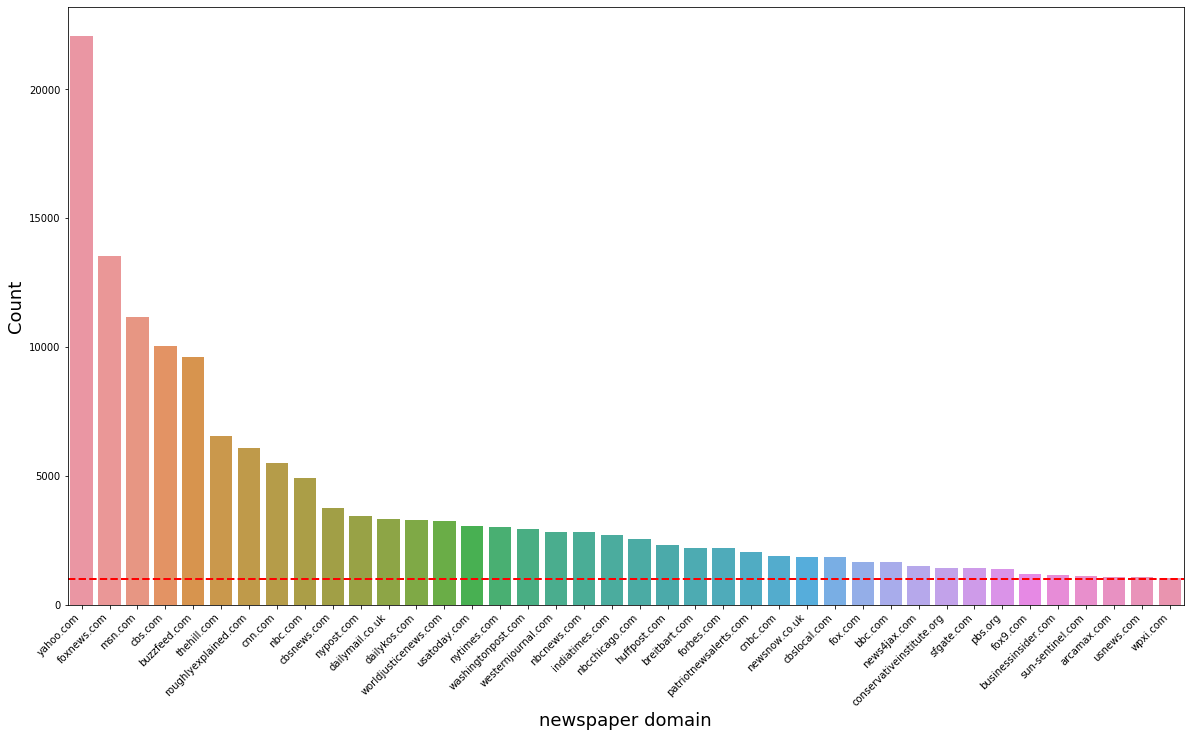

In [22]:
import seaborn 
plt.figure(figsize=(20,11)) 
ax=seaborn.barplot(x=domains_by_count['domain'].head(40), y=domains_by_count['occurrence'].head(40))
plt.xlabel('newspaper domain',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.axhline(domains_by_count['occurrence'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.xticks(rotation=45,ha='right')

In [23]:
print('The number of unique domains and subdomains:')
data.agg({"domain": "nunique","subdomain": "nunique"})

The number of unique domains and subdomains:


domain       187
subdomain    301
dtype: int64

In [24]:
data = data[data['check_url']==False]

In [25]:
print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 122780


In [26]:
data['url'].value_counts().head(20)
#.rename_axis('url').reset_index(name='counts')

www.roughlyexplained.com/viral-videos/?utm_source=prenc&utm_campaign=18q4                                                                       1444
msn.com/en-us/news/polls?civicscience-widget-version=4                                                                                           438
news.yahoo.com/colorado-climber-dies-reaching-top-160834778.html?ncid=eda_yahoonewsv_megkhcfaz8i                                                 306
news.yahoo.com/yahoo-news-daily-brief-may-205638582.html?ncid=eda_yahoonewsv_megkhcfaz8i                                                         137
worldjusticenews.com/jon-sander-live-stream2.htm                                                                                                 135
news.yahoo.com/documents-expose-political-motivation-behind-233746177.html?ncid=eda_yahoonewsv_megkhcfaz8i                                       131
news.yahoo.com/nevada-governor-signs-bill-restore-192036434.html?ncid=eda_yahoonewsv_megkhcfaz8i          

In [27]:
data['url_counts'] = data['url'].map(data['url'].value_counts())
data = data[data['url_counts']<= 150]

In [28]:
print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 120592


## 1.4. Title and Text filtering 

### 1.4.1. Text content filtering

In [29]:
data['url_counts'] = data['url'].map(data['url'].value_counts())
data['duration_counts'] = data['duration'].map(data['duration'].value_counts())
data['imgs_counts'] = data['imgs'].map(data['imgs'].value_counts())
data['text_counts'] = data['text'].map(data['text'].value_counts())
data['title_counts'] = data['title'].map(data['title'].value_counts())

In [201]:
text_counts = pd.DataFrame(data.text.value_counts())
text_threshold = 500
print(len(text_counts[text_counts['text'].between(text_threshold,max(text_counts['text']))]))
print(text_counts[text_counts['text'].between(text_threshold,max(text_counts['text']))]['text'].sum())

print(text_counts[text_counts['text'].between(text_threshold,text_threshold+10000)]['text'].sum())

print(313+251+164+136+131+130+120+792)

'''{500:[0,12783,9], 400:[0,13212,10],300:[313,15633,17], 200:[564,16857,22], 190:[564,17056,23], 180:[564,17056,20], 170:[564,17226,24],
 160:[728,17390,25], 150:[728,17699,27], 140:[728,17844,28], 130:[1125,18374,32], 120:[1245,18864,36], 110:[2037,19656,43],
100: [3878,20802],90:[4923,22034], 80: [5267,22548], 70:[5644,22925], 60:[5857,23684] , 50:[7524, 25711] }

'''
text_counts[text_counts['text'].between(text_threshold,text_threshold+100100)] .head(20)

0
0
0
2037


,text


In [135]:

text_counts[text_counts['text'].between(50,max(text_counts['text']))]['text'].sum()

8246

    threshold  relevant_lost  total_lost  unique_articles_lost  data_loss  \
0         500              0       12783                     9      0.000   
1         400              0       13212                    10      0.000   
2         300            313       15633                    17      0.340   
3         200            564       16857                    22      0.736   
4         190            564       17056                    23      0.761   
5         180            564       17056                    23      0.761   
6         170            564       17226                    24      0.786   
7         160            728       17390                    25      1.047   
8         150            728       17699                    27      1.111   
9         140            728       17844                    28      1.142   
10        130           1125       18374                    32      1.959   
11        120           1245       18864                    36      2.376   

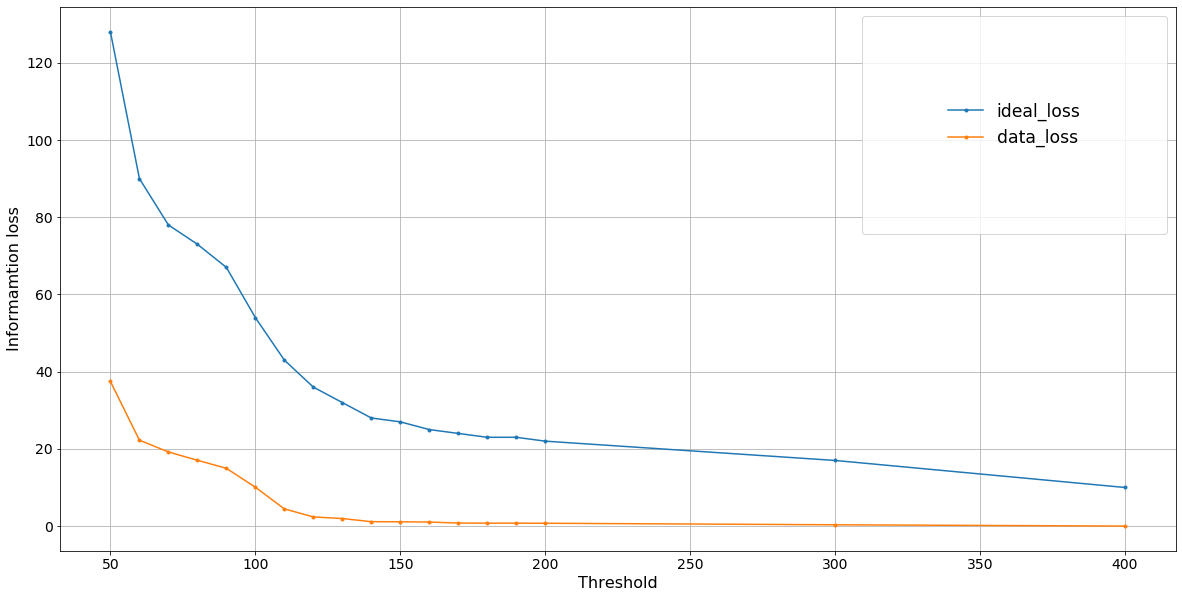

In [278]:
text_dict= {500:[0,12783,9], 400:[0,13212,10],300:[313,15633,17], 200:[564,16857,22], 190:[564,17056,23], 180:[564,17056,23], 170:[564,17226,24],
 160:[728,17390,25], 150:[728,17699,27], 140:[728,17844,28], 130:[1125,18374,32], 120:[1245,18864,36], 110:[2037,19656,43],
100: [3878,20802,54],90:[4923,22034,67], 80: [5267,22548,73], 70:[5644,22925,78], 60:[5857,23684,90] , 50:[7524, 25711,128] }


l= text_counts[text_counts['text'].between(50,max(text_counts['text']))]['text'].sum()
z = len(text_counts[text_counts['text'].between(50,max(text_counts['text']))])

df=pd.DataFrame.from_dict(text_dict,orient='index')

df['data_loss']=  round((df[2]) * (df[0]/df[1]), 3)
df = df.reset_index()
df = df.rename(columns={"index":"threshold", 0:"relevant_lost", 1:"total_lost", 2:"unique_articles_lost"})

def my_threshold_funct(x):
    k= int(df[df["threshold"]==x]["total_lost"])
    b= int(df[df["threshold"]==x]["unique_articles_lost"])
    
    y = b
    return y
df

df["ideal_loss"] = df['threshold'].apply(lambda row: my_threshold_funct(row) )
               
df.sort_values(by=['threshold'])
print(df)

ax1 = df.drop([0], axis=0).plot(x='threshold', y=["ideal_loss","data_loss"],figsize=(20, 10), grid=True,style='.-')
ax1.set_ylabel('Informamtion loss',fontdict={'fontsize':16})
ax1.set_xlabel('Threshold',fontdict={'fontsize':16})
plt.xticks(fontsize = 14 )
plt.yticks(fontsize = 14 )
plt.legend(loc='upper right',borderpad=5, fontsize= 'xx-large')


In [279]:
import math
distances = []
def distance(x,y):
    k= int(df[df["threshold"]==x]["total_lost"])
    b= int(df[df["threshold"]==x]["unique_articles_lost"])
    return abs((y - b)/(501 - x  ) )

threshold = list(df["threshold"])
fraction= list(df["data_loss"])
for i in range(len(df)):
    count= round(distance(threshold[i],fraction[i]),4)
    distances.append(count)
    
df["distance"]= distances
df["distance"][0] = "-" 

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/meftahzi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [281]:
copyDF(df)

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Threshold of text filtering for the US dataset')

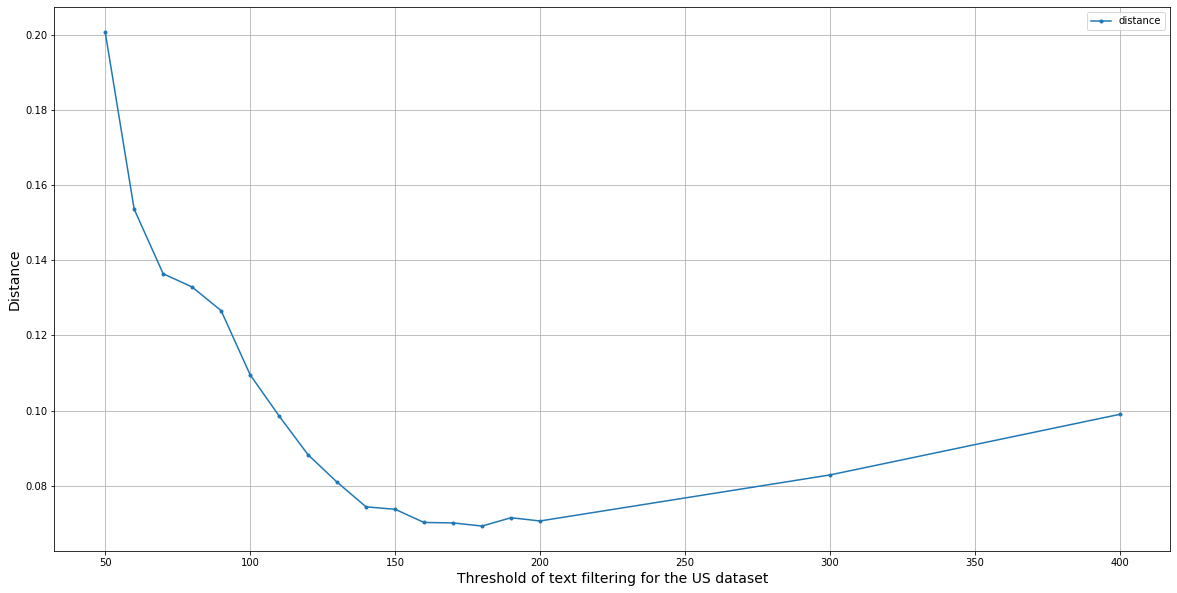

In [272]:
ax1 = df.drop([0], axis=0).plot(x='threshold', y=["distance"],figsize=(20, 10), grid=True,style='.-')
ax1.set_ylabel('Distance',fontdict={'fontsize':14})
ax1.set_xlabel('Threshold of text filtering for the US dataset',fontdict={'fontsize':14})

In [223]:
lt= []
for i in range(len(df)):
    if i == 0:
        lt.append(0)
    else: lt.append((df["distances"][0] - df["distances"][i])/(df["threshold"][0]- df["threshold"][i]))
df["distances%"]= lt

Text(0.5, 0, 'Threshold of UK text occurrences')

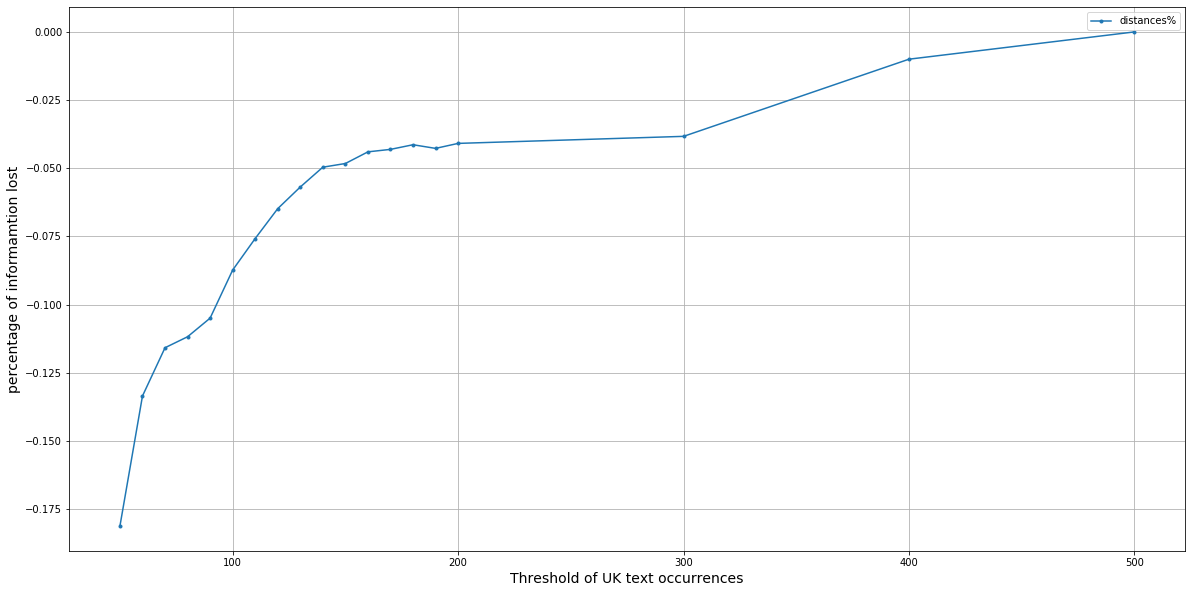

In [224]:
ax1 = df.plot(x='threshold', y=["distances%"],figsize=(20, 10), grid=True,style='.-')
ax1.set_ylabel('percentage of informamtion lost',fontdict={'fontsize':14})
ax1.set_xlabel('Threshold of UK text occurrences',fontdict={'fontsize':14})

In [34]:
#data = data[data['text_counts']<= int(df[df['distances'] ==max(df['distances'])]['threshold'])]
data = data[data['text_counts']<200]
print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 103735


### 1.4.2. Title filtering 

In [35]:
data['url_counts'] = data['url'].map(data['url'].value_counts())
data['duration_counts'] = data['duration'].map(data['duration'].value_counts())
data['imgs_counts'] = data['imgs'].map(data['imgs'].value_counts())
data['text_counts'] = data['text'].map(data['text'].value_counts())
data['title_counts'] = data['title'].map(data['title'].value_counts())

In [36]:
title_counts = pd.DataFrame(data.title.value_counts())
title_threshold = 137
title_counts[title_counts['title'].between(title_threshold,max(title_counts['title']))]

,title
Time,186
Article,141
The News In Cartoons,140
Wait Wait...Don't Tell Me!,138


In [37]:
# This code is for testing wether the urls are actual articles based on the title only.
data[data["title"]=="Time"]['text'].value_counts()

About Your Privacy on this SiteWelcome! Time collects data to deliver the best content, services, and personalized digital ads. We partner with third party advertisers, who may use tracking technologies to collect information about your activity on sites and applications across devices, both on our sites and across the Internet.You always have the choice to experience our sites without personalized advertising based on your web browsing activity by visiting the DAA’s Consumer Choice page, the NAI's website, and/or the EU online choices page, from each of your browsers or devices. To avoid personalized advertising based on your mobile app activity, you can install the DAA’s AppChoices app here. You can find much more information about your privacy choices in our privacy policy. You can make a Data Subject Request at any time. Even if you choose not to have your activity tracked by third parties for advertising services, you will still see non-personalized ads on our site.By clicking con

In [38]:
data = data[data['title_counts']< title_threshold]
print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 103130


## 1.5. Articles' indexing

> Later on, we are going to feed the LDA with the data after dropping the duplicates. <br>
Since one article could be read by different users, those deleted records need to be recovered to create the user topic profiles.  <br>
That's why we are giving articles <b>(combining title and text)</b> and their respective duplicates the same index.


In [39]:
data["combined"]= data["title"]+ ' ' + data["text"]+ ' ' + data['meta_keywords_first']

In [40]:
# each article and its duplicates will have a unique index
# if an article is not in "lt" list, we give it an index in "ind" and add it to "lt"
pub = list(data["combined"])
ind= []
lt= []
for i in range(len(pub)):

    if pub[i] not in lt :
        if i == 0 :
            ind.append(0)
            lt.append(pub[i])
        else : 
            ind.append(max(ind)+1) 
            lt.append(pub[i])
    else : 
        cout=lt.index(pub[i])
        ind.append(cout)
data["dup_index"]= ind

In [41]:
wrangled_data= data[['panelist_id',"combined","title","text","dup_index","url"]]
len(wrangled_data)

103130

# 2. Data preprocessing :

In [42]:
wrangled_data= wrangled_data.drop_duplicates(subset='combined', keep='first')
print("The remaining number of records is: " + str(len(wrangled_data)))

The remaining number of records is: 37890


In [43]:
# Get rid of records where title is the text  
wrangled_data=wrangled_data[wrangled_data["title"]!=wrangled_data["text"]]
print("The remaining number of records is: " + str(len(wrangled_data)))

The remaining number of records is: 37869


## 2.1. Delete handles, image caption/credits, links, money amounts, phone numbers, and navigation menus

In [44]:
r_ignore_case = {
    'handle': r'\S+@\S+',
    'link': r'((visit|at)\s+)*(\S+).(com|org)((/|\S)*)',
    'money': r'\$\d*',
    'phone': r'(\d-)*(\d+-\d+-\d+)' ,
    'menu': r'(?<=•)[^•]*(?=•)'
}
r_set_case = {
    'photographer-credits': r'PHOTO(GRAPHER)*:(\s)*(([A-Z][A-Za-z]*)\s*){1,3}',
    'graphics': r'Graphic([^.])'
}

In [45]:
def filter_text(text):
    for regex in r_ignore_case:
        text = re.sub(regex, '', text, re.I)
    for regex in r_set_case:
        text = re.sub(regex, '', text)
    text =  re.sub(r'[©,(-.:;“"@#?!&$/_\‘―%)’”]+', ' ', text) 
    text = re.sub(r'[0-9]+', ' ', text)
    return(" ".join(text.split()))

## 2.3. Remove anything that is not a letter or number, lowercase, tokenize

In [46]:
from spacy.lang.en import English
nlp = English()
def process_text(text):
    text = text.lower() 
    text = nlp(text)
    token_list = []
    for token in text:
        token_list.append(str(token.text))
    return ' '.join(token_list)

## 2.4. Remove Stopwords 

> This is a personalized list of stopwords. <br><b>"stopwords_other"</b> is a list of words that were showing in the topic keywords but weren't relevant.

In [47]:
from spacy.lang.en.stop_words import STOP_WORDS

url = "https://countwordsfree.com/stopwords/english/json"
response = pd.DataFrame(data = json.loads(requests.get(url).text))
SW = list(response[0])
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'image', 'de', 'en', 'caption', 'also', 'copyright', 'something', 
                   'nh', "getty", "pa","don","ap","afp","reuter","picture", "ve", "didn", "share","september","–","–","£","—","  ","\'",
                   "august","october","jo","thoma","june","july","fox","bu","nz", "reaction","copyright", "media", "playback",
                   "unsupported" ,"device","st","ms","dog","afpgetty","slide", "people", "san_francisco", "city", 
                   "time", "lee", "los_angeles","day", "news", "fl", "pause_gif","pic_twitter","include","cbs","james","april","may",
                   "feel" ,"twitter", "facebook" ,"slide", "photo" ,"jones" , "reuters_slide" ,"affiliate_commission","purchase_recommend"
                   ,"microsoft_earn" ,"inch","images_slide" ,"link_article","barr" ,"turn",'long']
my_stopwords = SW + stopwords_verbs + stopwords_other

def remove_stopwords_1(text):
    #Implementation of stop words:
    filtered_sent = []

    #  "nlp" Object is used to create documents with linguistic annotations.
    doc = nlp(text)

    # filtering stop words
    for word in doc:
        if word.is_stop==False:
            filtered_sent.append(word)
        else:
            continue
    filtered_sent = [word for word in filtered_sent if not word.text in my_stopwords and word.pos_ != "PUNCT"]
    return ' '.join([str(elem).replace("'","") for elem in filtered_sent]) 


def remove_stopwords_2(text):
    return [word for word in text if not word in my_stopwords]

In [283]:
copyDF(pd.DataFrame(stopwords_other))

<IPython.core.display.Javascript object>

## 2.2.  Stemming and lemmatization

In [48]:
import en_core_web_sm

In [49]:
pb = en_core_web_sm.load()
def lemmatize(text):
    lt=[]
    lem = pb(text)
    for word in lem:
        lt.append(word.lemma_)
    return lt

In [50]:
# Gathering all preprocessing functions uder one function and apply it to the combined column
def clean_text(text):
    text = filter_text(text)
    text = process_text(text)
    text = remove_stopwords_1(text)
    text = " ".join(text.split())
    text = lemmatize(text)
    text = remove_stopwords_2(text)
    text = [word for word in text if not word in  r'[©,(-.:;“"@#?!&$/_\‘―%)’”]+']
    return text

In [51]:
wrangled_data['clean_text']=wrangled_data['combined'].apply(lambda x: clean_text(x))

In [52]:
# Add column That shows the number of words per article to filter out the article shorter than a threshold.
wrangled_data['length']=wrangled_data['clean_text'].apply(lambda x: len(x))

Text(500, 1000, 'The average value :232.05912487786844 words')

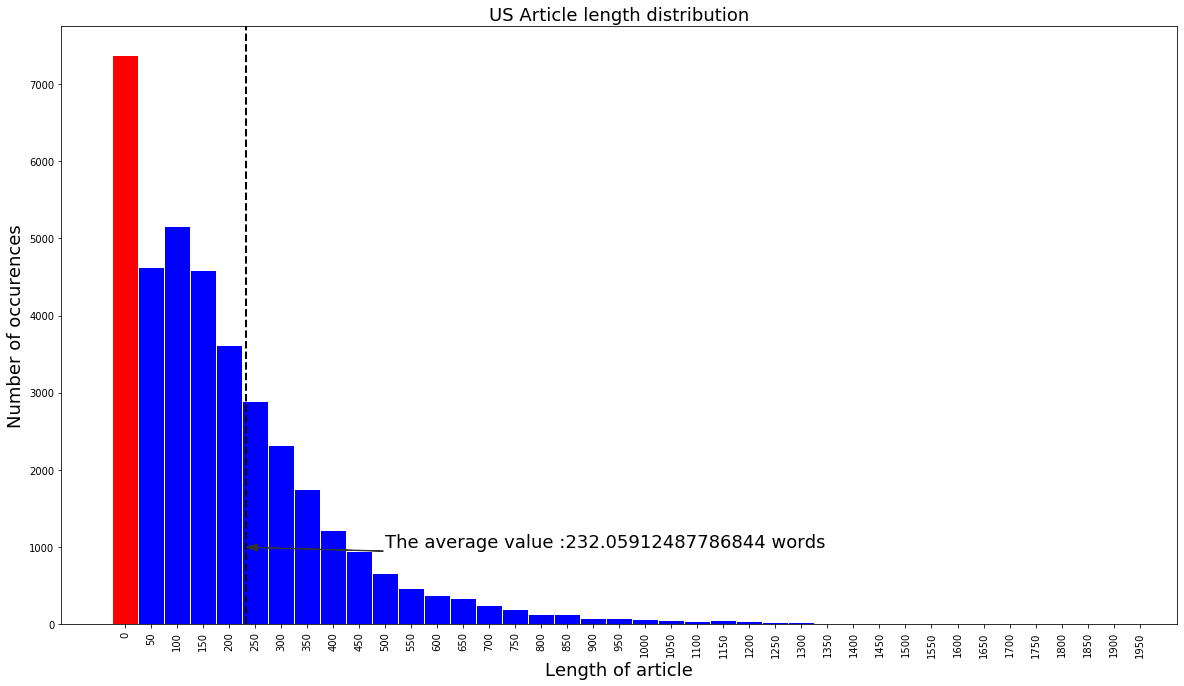

In [53]:
#plotting the Article length distribution
plt.figure(figsize=(20,11)) 

plt.xlabel("Length of article",fontsize=18)
plt.ylabel("Number of occurences",fontsize=18)
plt.title("US Article length distribution",fontsize=18)
n, bins, patches = plt.hist(wrangled_data['length'],bins=range(0, 2000, 50),align='left', edgecolor='white',color='b')
plt.xticks(range(0, 2000, 50))
plt.xticks(rotation=90)
#Set the max value manually patches[max index]
patches[0].set_fc('r')
plt.axvline(wrangled_data['length'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.annotate('The average value :'+str(wrangled_data['length'].mean())+ " words" , xy=(wrangled_data['length'].mean(), 1000), xytext=(500, 1000), fontsize=18, arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})

In [54]:
#kepping only articles with length superior to 10
processed_data=wrangled_data[wrangled_data["length"]>20]
print("The remaining number of records is: " + str(len(processed_data)))

The remaining number of records is: 34633


In [55]:
# this is the data we feed our LDA 
data_lemmatized = list(processed_data['clean_text'])

In [56]:
# this is the data we feed our LDA 
import csv
data_lemmatized = list(processed_data['clean_text'])
with open("processed_us_data", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(data_lemmatized)

> We compute bigrams in the articles. Bigrams are sets of two adjacent words. Using bigrams, we can get phrases like "email_address" in our output (spaces are replaced with underscores).

In [57]:
bigram = gensim.models.Phrases(data_lemmatized, min_count=20, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [58]:
texts = [bigram_mod[doc] for doc in data_lemmatized]

In [59]:
# Create Dictionary
id2word = corpora.Dictionary(texts)
# Filter out words that occur less than 30 documents, or more than 30% of the documents.
id2word.filter_extremes(no_below=2,no_above=0.5)
# Create Corpus
texts = texts

In [60]:
corpus = [id2word.doc2bow(text) for text in texts]

In [61]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 79558
Number of documents: 34633


# 3. Topic Modeling using LDA 

## 3.1. Finding Optimal number of topics 

In [62]:
# range of topics you want to compute LDA for 
min_topic = 1
max_topic = 40
numberoftopics= list(range(min_topic,max_topic+1))

In [63]:
#Sampling test data for perplexity 
# sample 1/300
import math 
from random import sample 
testset=sample(corpus,int(len(corpus)/300))

> In this part, we build multiple LDA models with different number of topics. <br> 
We compute the coherence score and perplexity score for each model.<br> These will be used to evaluate our LDA results and get the optimal number of topics.<br> 


In [64]:
#Perplexity Score implementation : 

def perplexity(ldamodel, testset, dictionary, size_dictionary, num_topics):
    """calculate the perplexity of a lda-model"""
    # dictionary : {7822:'deferment', 1841:'circuitry',19202:'fabianism'...]
    print ('the info of this ldamodel: \n')
    print ('num of testset: %s; size_dictionary: %s; num of topics: %s'%(len(testset), size_dictionary, num_topics))
    prep = 0.0
    prob_doc_sum = 0.0
    topic_word_list = [] # store the probablity of topic-word:[(u'business', 0.010020942661849608),(u'family', 0.0088027946271537413)...]
    for topic_id in range(num_topics):
        topic_word = ldamodel.show_topic(topic_id, size_dictionary)
        dic = {}
        for word, probability in topic_word:
            dic[word] = probability
        topic_word_list.append(dic)
    doc_topics_ist = [] #store the doc-topic tuples:[(0, 0.0006211180124223594),(1, 0.0006211180124223594),...]
    for doc in testset:
        doc_topics_ist.append(ldamodel.get_document_topics(doc, minimum_probability=0))
    testset_word_num = 0
    for i in range(len(testset)):
        prob_doc = 0.0 # the probablity of the doc
        doc = testset[i]
        doc_word_num = 0 # the num of words in the doc
        for word_id, num in doc:
            prob_word = 0.0 # the probablity of the word 
            doc_word_num += num
            word = dictionary[word_id]
            for topic_id in range(num_topics):
                # cal p(w) : p(w) = sumz(p(z)*p(w|z))
                prob_topic = doc_topics_ist[i][topic_id][1]
                prob_topic_word = topic_word_list[topic_id][word]
                prob_word += prob_topic*prob_topic_word
            prob_doc += math.log(prob_word) # p(d) = sum(log(p(w)))
        prob_doc_sum += prob_doc
        testset_word_num += doc_word_num
    prep = math.exp(-prob_doc_sum/testset_word_num) # perplexity = exp(-sum(p(d)/sum(Nd))
    print ("the perplexity of this ldamodel is : %s"%prep)
    return prep

In [65]:
# Build LDA model
cv_coherence_values = []
uci_coherence_values = []
umass_coherence_values = []
model_list = []
perplexity_values =[]
for i in numberoftopics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                                id2word = id2word,
                                                num_topics =i , 
                                                alpha = 0.1,
                                                eta= 0.01,
                                                iterations=50,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=2000,
                                                passes=4)
    model_list.append(lda_model)

    print("------------------------------------------------")
    print("number of topics" , i)
    perplexity_values.append(perplexity(lda_model, testset, id2word, len(id2word), i))
    cv_coherence_values.append(CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v').get_coherence())
    uci_coherence_values.append(CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_uci').get_coherence())
    umass_coherence_values.append(CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass').get_coherence())

------------------------------------------------
number of topics 1
the info of this ldamodel: 

num of testset: 115; size_dictionary: 79558; num of topics: 1
the perplexity of this ldamodel is : 342.4670540181892
------------------------------------------------
number of topics 2
the info of this ldamodel: 

num of testset: 115; size_dictionary: 79558; num of topics: 2
the perplexity of this ldamodel is : 316.5733144335202
------------------------------------------------
number of topics 3
the info of this ldamodel: 

num of testset: 115; size_dictionary: 79558; num of topics: 3
the perplexity of this ldamodel is : 303.66967211404045
------------------------------------------------
number of topics 4
the info of this ldamodel: 

num of testset: 115; size_dictionary: 79558; num of topics: 4
the perplexity of this ldamodel is : 296.9999453712334
------------------------------------------------
number of topics 5
the info of this ldamodel: 

num of testset: 115; size_dictionary: 79558; n

In [66]:
# Build LDA model
cv_coherence_values_2 = []
uci_coherence_values_2 = []
umass_coherence_values_2 = []
model_list_2 = []
perplexity_values_2 =[]
for i in numberoftopics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                                id2word = id2word,
                                                num_topics =i , 
                                                alpha = 0.1,
                                                eta= 0.001,
                                                iterations=50,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=2000,
                                                passes=4)
    model_list_2.append(lda_model)

    print("------------------------------------------------")
    print("number of topics" , i)
    perplexity_values_2.append(perplexity(lda_model, testset, id2word, len(id2word), i))
    cv_coherence_values_2.append(CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v').get_coherence())
    uci_coherence_values_2.append(CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_uci').get_coherence())
    umass_coherence_values_2.append(CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass').get_coherence())

------------------------------------------------
number of topics 1
the info of this ldamodel: 

num of testset: 115; size_dictionary: 79558; num of topics: 1
the perplexity of this ldamodel is : 375.87766780073645
------------------------------------------------
number of topics 2
the info of this ldamodel: 

num of testset: 115; size_dictionary: 79558; num of topics: 2
the perplexity of this ldamodel is : 347.7948596384479
------------------------------------------------
number of topics 3
the info of this ldamodel: 

num of testset: 115; size_dictionary: 79558; num of topics: 3
the perplexity of this ldamodel is : 334.2485705371984
------------------------------------------------
number of topics 4
the info of this ldamodel: 

num of testset: 115; size_dictionary: 79558; num of topics: 4
the perplexity of this ldamodel is : 327.0065149657105
------------------------------------------------
number of topics 5
the info of this ldamodel: 

num of testset: 115; size_dictionary: 79558; n

In [68]:
def display_topics(model):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=10)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    df = pd.DataFrame(topics)
    df.columns = ['keyword {0}'.format(i) for i in range(1, 10+1)]
    return df

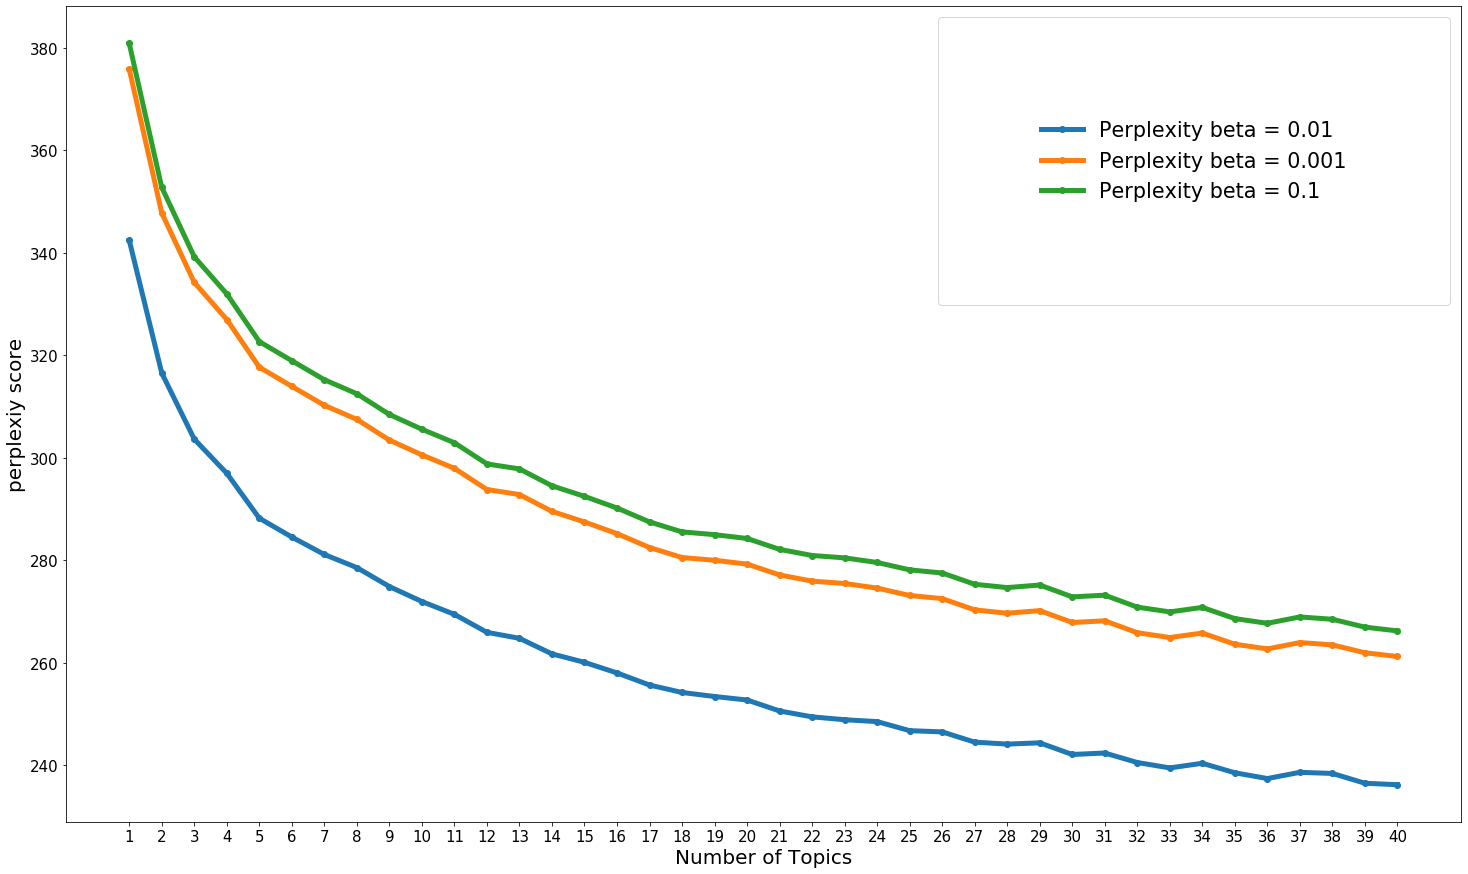

In [296]:
#eta_1= 0.01
#eta_2= 0.001
evaluation_measures = pd.DataFrame(
    {'Number_topics': numberoftopics,
     'Perplexity beta = 0.01': perplexity_values,
     'Perplexity beta = 0.001': perplexity_values_2,
     'Perplexity beta = 0.1': perplexity_values_3 ,
     'U_mass': umass_coherence_values,
     'C_V': cv_coherence_values ,
     'UCI':uci_coherence_values
    })

evaluation_measures.plot(x="Number_topics",y=["Perplexity beta = 0.01","Perplexity beta = 0.001","Perplexity beta = 0.1"],figsize=(25,15),   linestyle='-', linewidth=5, marker='o',fontsize=15)
plt.xlabel("Number of Topics", fontsize=20)
plt.ylabel("perplexiy score", fontsize=20)
#plt.axvline(x=8, linewidth=2, color='b', linestyle='--' )
#plt.axvline(x=28, linewidth=2, color='b', linestyle='--' )
#plt.axvline(x=25, linewidth=2, color='b', linestyle='--' )
plt.gca().set_xticks(evaluation_measures["Number_topics"].unique())
#plt.title(("perp value for different number of topics on US data"),fontsize=20)

plt.legend(loc='upper right',borderpad=5, fontsize= 'xx-large')
plt.show()

In [199]:
def copyDF( df ):
    '''
    A function that copies a dataframe to your clipboard when run in Jupyter.
    
    Args:
        * df (``pandas.DataFrame``): a dataframe to copy to the local clipboard
    
    Returns:
        None
    '''
    ipy = get_ipython()
    ipy.run_cell_magic( "javascript", "",
        '''
        function copyToClipboard(text) {
            if ( window.clipboardData && window.clipboardData.setData ) { return clipboardData.setData( "Text", text ); }
            else if ( document.queryCommandSupported && document.queryCommandSupported( "copy" ) ) {
                var textarea = document.createElement( "textarea" );
                textarea.textContent = text;
                textarea.style.position = "fixed";  // Prevent scrolling to bottom of page in Microsoft Edge.
                document.body.appendChild( textarea );
                textarea.select();
                try { return document.execCommand( "copy" ); }
                catch ( ex ) {
                    console.warn( "Copy to clipboard failed.", ex );
                    return false;
                }
                finally { document.body.removeChild( textarea ); }
            }
        };
        copyToClipboard( "%s" );
        ''' % ( "{}{}".format( 
                "\t{}\\n".format( "\t".join( [ str( df.columns[ c ] ) for c in range( len( df.columns ) ) ] ) ),
                "\\n".join( [ "{}\t{}".format( str( df.index[ r ] ), "\t".join( [ str( df.iloc[ r, c ] ) for c in range( len( df.columns ) ) ] ) ) for r in range( len( df ) ) ] )
            ) ) )

In [367]:
#based on the previous figure 
import random 
eval_data= display_topics(model=model_list[22])
l= list(eval_data["keyword 1"])
print(eval_data)
shuffled_words_intrusion = random.sample(l, len(l))
eval_data["keyword 1"]= shuffled_words_intrusion
shuffled_eval =pd.DataFrame(np.apply_along_axis(np.random.permutation, 1, eval_data))
shuffled_eval['intruder']=shuffled_words_intrusion

    keyword 1      keyword 2    keyword 3   keyword 4       keyword 5  \
0        star           love         film        work            play   
1      border         mexico  immigration     migrant            wall   
2       house         senate   republican        vote        congress   
3       trump      president     military     country        official   
4     company           work      service      online          amazon   
5   cathedral     notre_dame       church       paris          french   
6      charge           case        court    attorney          prison   
7        wear          royal        dress       queen            good   
8       trump      president       report     mueller           house   
9       child         family         life      mother          parent   
10       food     restaurant        house        live           local   
11      study          human        plant      animal  climate_change   
12      water           area          car       cra

In [368]:
copyDF(display_topics(model=model_list[21]))

<IPython.core.display.Javascript object>

In [369]:
copyDF(shuffled_eval)

<IPython.core.display.Javascript object>

'''finding the optimal number of topics is to build
many LDA models with different values of number of topics (k) 
and pick the one that gives the highest coherence value.
Best coherence for umass is typically the minimum
'''

In [305]:
evaluation_measures = pd.DataFrame(
    {'Number_topics': numberoftopics,
     'Perplexity': [round(num, 3) for num in perplexity_values],
     'U_mass': [round(num, 3) for num in umass_coherence_values],
     'C_V': [round(num, 3) for num in cv_coherence_values],
     'UCI':[round(num, 3) for num in uci_coherence_values]
    })
evaluation_measures

,Number_topics,Perplexity,U_mass,C_V,UCI
0,1,342.467,-1.267,0.279,-0.144
1,2,316.573,-1.210,0.509,0.256
2,3,303.670,-1.325,0.522,0.321
3,4,297.000,-1.347,0.510,0.295
4,5,288.237,-1.799,0.537,0.406
5,6,284.563,-1.988,0.539,0.414
6,7,281.159,-1.959,0.544,0.380
7,8,278.603,-1.887,0.533,0.442
8,9,274.904,-2.036,0.498,0.345
9,10,271.979,-1.950,0.536,0.438


In [306]:
copyDF(evaluation_measures)

<IPython.core.display.Javascript object>

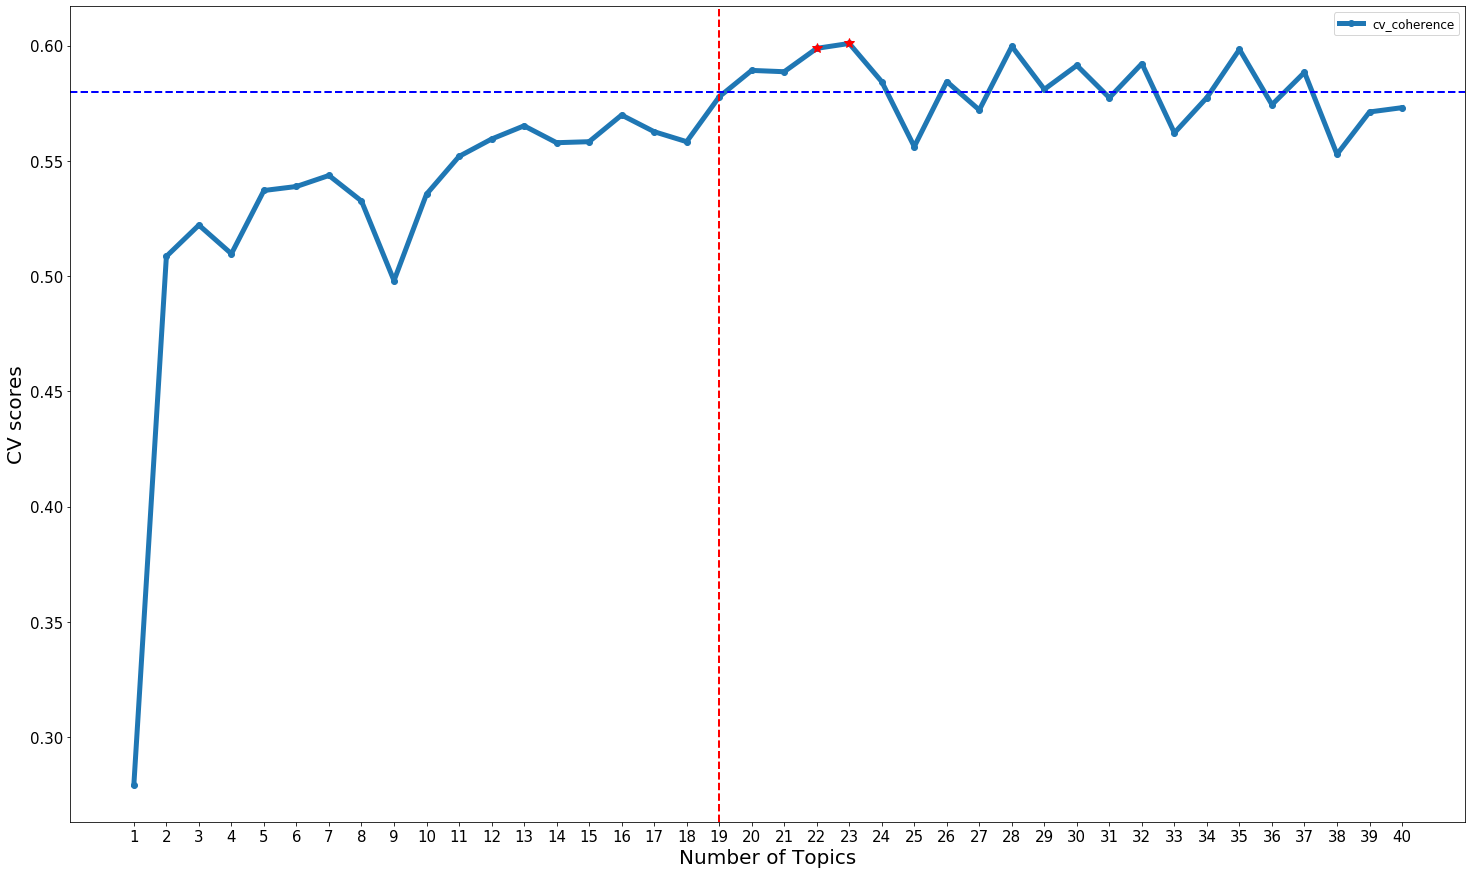

In [333]:
def Average(lst): 
    return sum(lst) / len(lst) 
# Show graph
plots = pd.DataFrame({"topics" : numberoftopics ,
                     "cv_coherence" :cv_coherence_values ,
                     "uci_coherence" :uci_coherence_values})
plots.plot(x="topics",y="cv_coherence",figsize=(25,15),   linestyle='-', linewidth=5, marker='o',fontsize=15)
plt.xlabel("Number of Topics", fontsize=20)
plt.ylabel("CV scores", fontsize=20)
#plt.title(("CV coherence value relative to the number of topics on US data"),fontsize=20)
plt.axvline(x=19, linewidth=2, color='r', linestyle='--' )
plt.axhline(y=0.58, linewidth=2, color='b', linestyle='--' )
plt.plot(22, cv_coherence_values[21], 'r*',markersize=10)
plt.plot(23, cv_coherence_values[22], 'r*',markersize=10)
plt.gca().set_xticks(plots["topics"].unique())
#plt.legend(loc='lower right',borderpad=5, fontsize= 'xx-large')
plt.show()

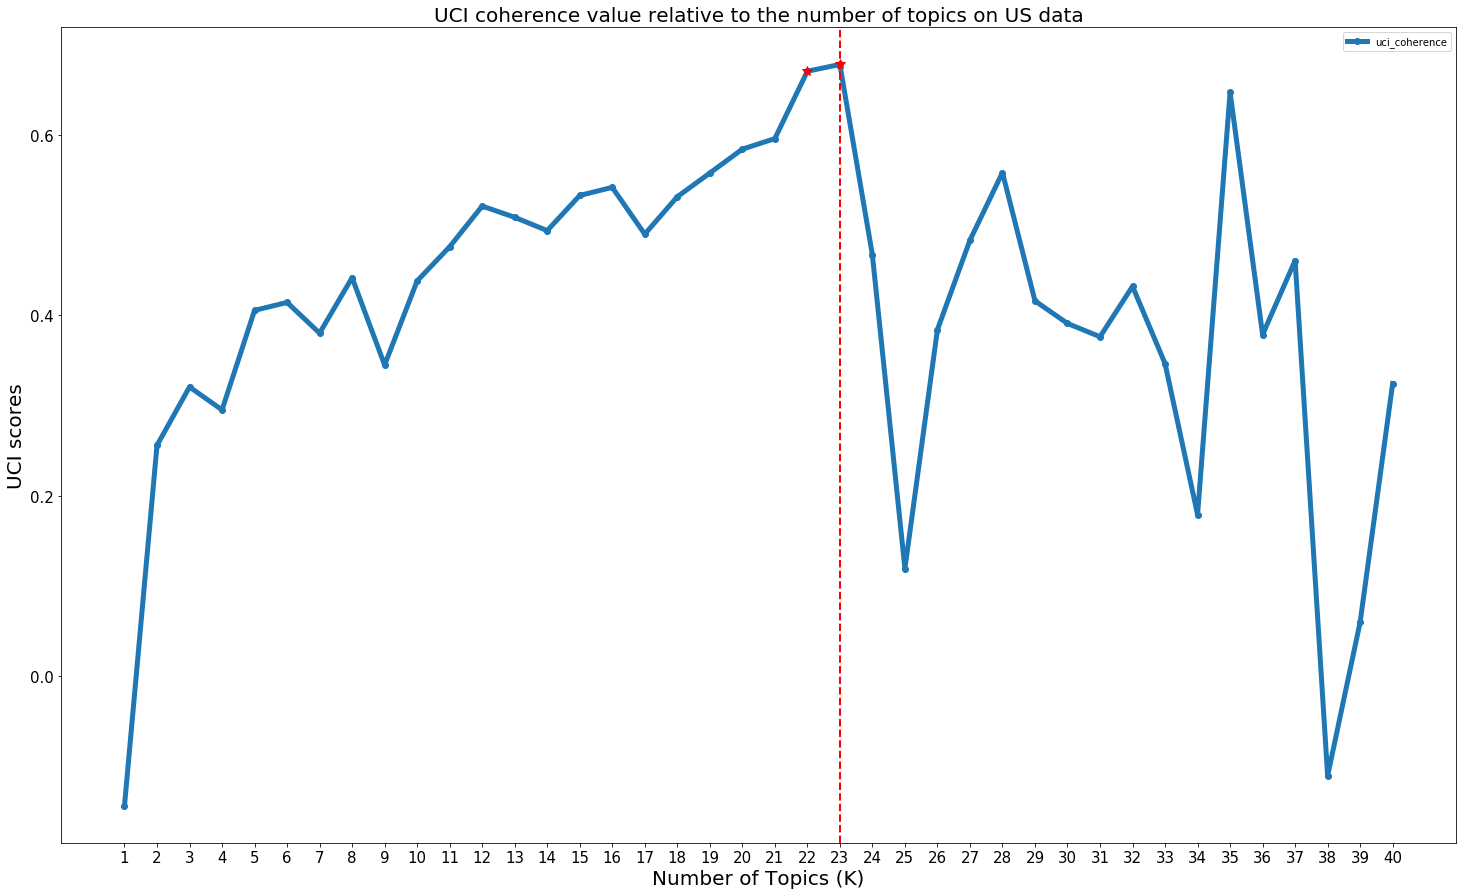

In [130]:
def Average(lst): 
    return sum(lst) / len(lst) 
# Show graph
plots = pd.DataFrame({"topics" : numberoftopics ,
                     "cv_coherence" :cv_coherence_values ,
                     "uci_coherence" :uci_coherence_values})
plots.plot(x="topics",y=["uci_coherence"],figsize=(25,15),   linestyle='-', linewidth=5, marker='o',fontsize=15)
plt.xlabel("Number of Topics (K)", fontsize=20)
plt.ylabel("UCI scores", fontsize=20)
plt.title(("UCI coherence value relative to the number of topics on US data"),fontsize=20)
plt.axvline(x=23, linewidth=2, color='r', linestyle='--' )
plt.plot(22, uci_coherence_values[21], 'r*',markersize=10)
plt.plot(23, uci_coherence_values[22], 'r*',markersize=10)
plt.plot(22, umass_coherence_values[21], 'r*',markersize=10)
plt.gca().set_xticks(plots["topics"].unique())
#plt.ylim([-1,1])
plt.show()

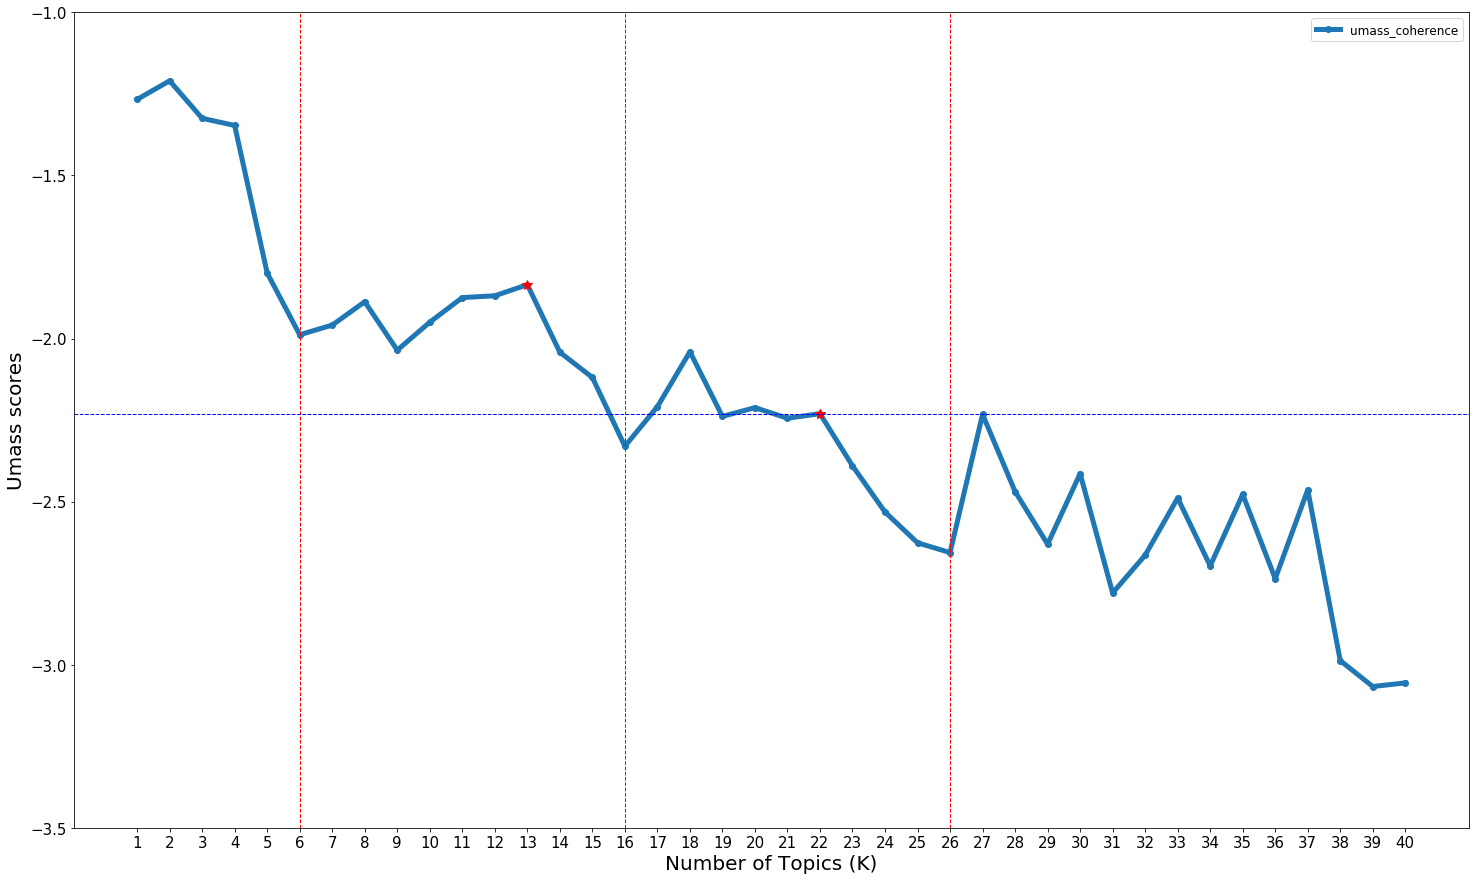

In [351]:
# Show graph
plots = pd.DataFrame({"topics" : numberoftopics ,
                     "umass_coherence" :umass_coherence_values})
plots.plot(x="topics",y="umass_coherence",figsize=(25,15),   linestyle='-', linewidth=5, marker='o',fontsize=15)
plt.xlabel("Number of Topics (K)", fontsize=20)
plt.ylabel("Umass scores", fontsize=20)
#plt.title(("Umass coherence value relative to the number of topics on US data"),fontsize=20)
plt.axvline(x=6, linewidth=1, color='r', linestyle='--' )
plt.axvline(x=16, linewidth=1, color='r', linestyle='--' )
plt.axvline(x=26, linewidth=1, color='r', linestyle='--' )
#plt.axvline(x=26, linewidth=2, color='b', linestyle='--' )
plt.gca().set_xticks(plots["topics"].unique())
plt.plot(13, umass_coherence_values[12], 'r*',markersize=10)
plt.plot(22, umass_coherence_values[21], 'r*',markersize=10)
plt.plot(22, umass_coherence_values[21], 'r*',markersize=10)
plt.axhline(y=-2.23, linewidth=1, color='b' ,  linestyle='--')

plt.ylim([-3.5,-1])
plt.show()

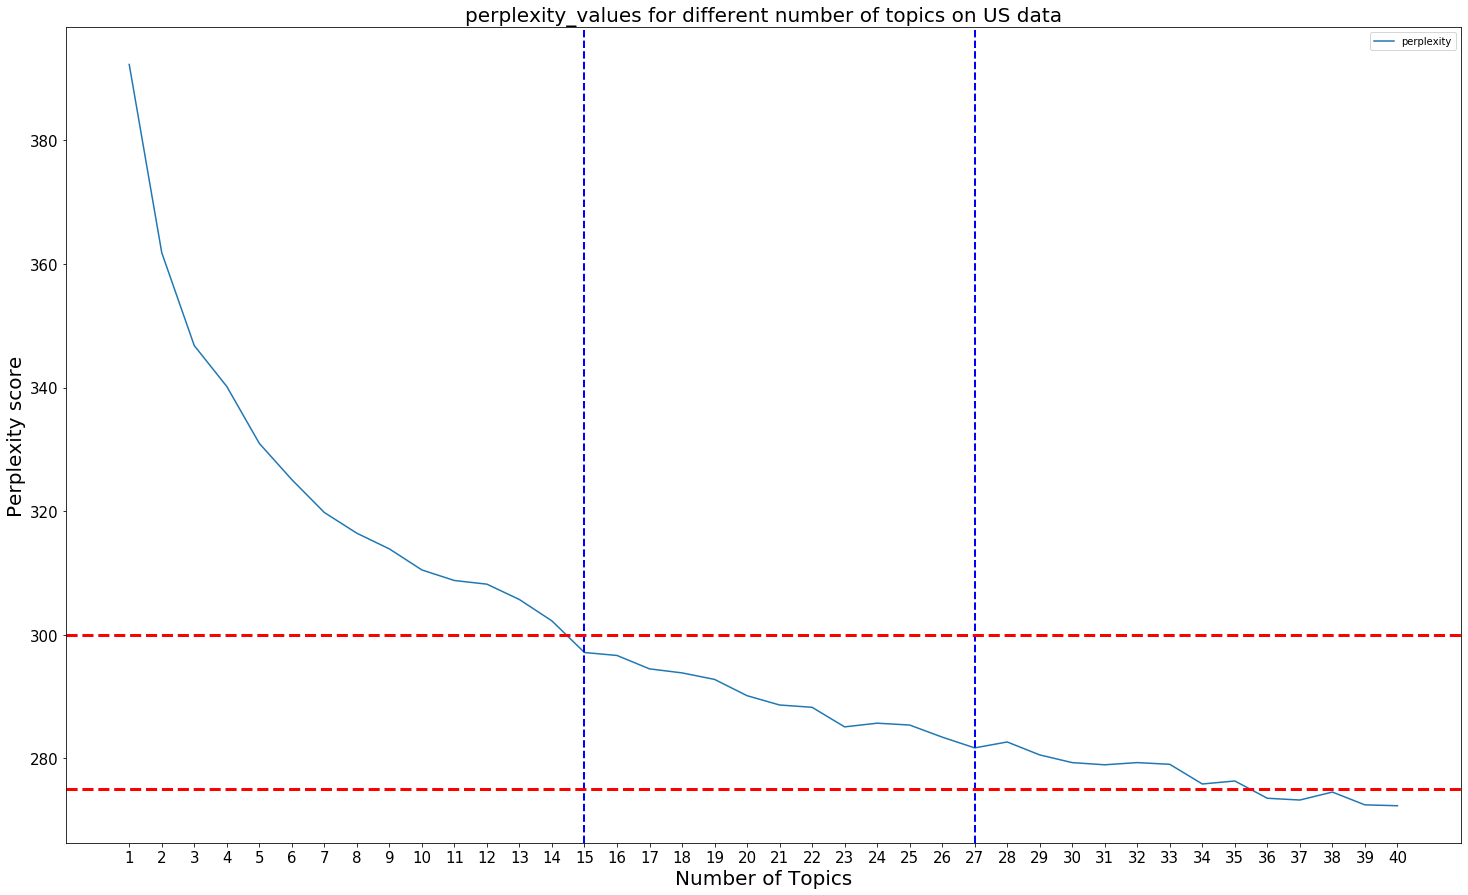

In [121]:
# Show graph


plots = pd.DataFrame({"topics" : numberoftopics ,
                     "perplexity" :perplexity_values })
plots.plot(x="topics",y="perplexity",figsize=(25,15),fontsize=15)
plt.xlabel("Number of Topics", fontsize=20)
plt.ylabel("Perplexity score", fontsize=20)
plt.gca().set_xticks(plots["topics"].unique())
plt.axvline(x=15, linewidth=2, color='b', linestyle='--' )
plt.axvline(x=27, linewidth=2, color='b', linestyle='--' )
#plt.axvline(x=26, linewidth=2, color='b', linestyle='--' )
plt.axhline(y=300, linewidth=3, color='r', linestyle='--' )
plt.axhline(y=275, linewidth=3, color='r', linestyle='--' )
plt.title(("perplexity_values for different number of topics on US data"),fontsize=20)
plt.show()


In [352]:
 display_topics(model=model_list[14])

,keyword 1,keyword 2,keyword 3,keyword 4,keyword 5,keyword 6,keyword 7,keyword 8,keyword 9,keyword 10
0,play,win,star,season,game,good,love,fan,big,night
1,police,border,child,mexico,report,family,migrant,boy,immigration,official
2,vote,law,democratic,biden,abortion,candidate,senate,campaign,republican,support
3,country,president,trump,government,military,china,american,official,united,war
4,company,pay,work,business,percent,cost,price,tax,service,job
5,cathedral,notre_dame,building,island,paris,park,animal,church,flight,french
6,police,man,officer,kill,car,shoot,gun,arrest,county,charge
7,wear,instagram,baby,royal,dress,black,house,shoe,pair,couple
8,trump,president,report,mueller,house,donald,white,democrats,congress,special_counsel
9,woman,child,life,family,work,parent,mother,love,man,live


In [882]:
# Checking the number of duplicated keywords in generated Topics

In [329]:
words =  display_topics(model=model_list[34]).values.tolist()
words =  [item for sublist in words for item in sublist] 
for i in range(0, len(words)):  
    count = 1;  
    for j in range(i+1, len(words)):  
        if(words[i] == (words[j])):  
            count = count + 1;  
            #Set words[j] to 0 to avoid printing visited word  
            words[j] = "0";  
              
    #Displays the duplicate word if count is greater than 1  
    if(count > 1 and words[i] != "0"):  
        print(words[i], count);  

love 2
family 4
friend 2
life 4
trump 5
country 2
official 3
house 3
congress 2
vote 2
democrats 3
president 3
government 2
work 4
product 2
report 3
white 2
investigation 2
woman 2
man 3
parent 2
water 3
high 4
group 2
post 2
comment 2
campaign 2
food 2
season 2
watch 2
character 2
kill 2
arrest 2
law 2
ban 2
play 2
trade 2
democratic 2
election 2
rule 2
case 3
court 2
good 2


In [95]:
for i  in [22,17]:
    model_list[i].save("us_model{}.gensim".format(i))

In [153]:
#based on the previous figure 
import random 
eval_data= display_topics(model=model_list[22])
l= list(eval_data["keyword 1"])
print(eval_data)
shuffled_words_intrusion = random.sample(l, len(l))
eval_data["keyword 1"]= shuffled_words_intrusion
shuffled_eval =pd.DataFrame(np.apply_along_axis(np.random.permutation, 1, eval_data))
shuffled_eval['intruder']=shuffled_words_intrusion

    keyword 1      keyword 2    keyword 3   keyword 4       keyword 5  \
0        star           love         film        work            play   
1      border         mexico  immigration     migrant            wall   
2       house         senate   republican        vote        congress   
3       trump      president     military     country        official   
4     company           work      service      online          amazon   
5   cathedral     notre_dame       church       paris          french   
6      charge           case        court    attorney          prison   
7        wear          royal        dress       queen            good   
8       trump      president       report     mueller           house   
9       child         family         life      mother          parent   
10       food     restaurant        house        live           local   
11      study          human        plant      animal  climate_change   
12      water           area          car       cra

In [ ]:
#enter the optimal number of topics 
lda_model=model_list[22]
#14-16-19-21

In [156]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[17], corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.168334  0.125752       1        1  9.877995
17     0.038445  0.049512       2        1  7.728500
16     0.164308  0.122701       3        1  7.615674
4     -0.051871 -0.132441       4        1  7.387605
14    -0.184882  0.071894       5        1  7.170338
9      0.022977  0.116128       6        1  6.734880
13    -0.055996  0.126938       7        1  6.572760
2     -0.164354  0.024918       8        1  5.828395
0      0.145463  0.084482       9        1  5.808014
7      0.224177  0.044073      10        1  5.106353
12     0.091603 -0.173311      11        1  4.935593
3     -0.158765 -0.025751      12        1  4.658376
15     0.019048 -0.154872      13        1  4.624623
6      0.077347 -0.018085      14        1  4.176924
5      0.073481  0.118176      15        1  3.633691
10     0.183304 -0.154034      16        1  3.048316
1     -0.179456 -0.099904      17        1  2.667954
11    -0.076493 -0.126176      18        1  2.424007, topic_info=           Term          Freq         Total Category  logprob  loglift
98        trump  81062.000000  81062.000000  Default  30.0000  30.0000
2057     police  22921.000000  22921.000000  Default  29.0000  29.0000
90    president  42029.000000  42029.000000  Default  28.0000  28.0000
778      school  15226.000000  15226.000000  Default  27.0000  27.0000
1264    mueller  16984.000000  16984.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
44       report   1209.603638  41278.710938  Topic18  -5.0962   0.1897
50       social    879.563904   7660.188477  Topic18  -5.4148   1.5554
964       email    834.295105   5594.492188  Topic18  -5.4676   1.8168
1001   official    971.619446  16699.205078  Topic18  -5.3153   0.8756
61        video    874.532288  11363.661133  Topic18  -5.4205   1.1553

[1450 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
17159      6  0.999411         <_>
28046     16  1.000966         =_=
5044       2  1.000208      abduct
1955       6  0.956286    abortion
1955       8  0.043591    abortion
...      ...       ...         ...
13295     10  0.046322         zoo
13295     18  0.910996         zoo
6347       4  1.000236         zte
22692     12  0.998739  zuckerberg
16941     15  0.995874           °

[6388 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 18, 17, 5, 15, 10, 14, 3, 1, 8, 13, 4, 16, 7, 6, 11, 2, 12])

In [157]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[21], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.186257  0.111885       1        1  9.474559
9      0.047982  0.037349       2        1  8.800112
17     0.019361  0.109564       3        1  7.327942
14    -0.184632  0.049034       4        1  6.289376
0      0.179516  0.133605       5        1  5.928873
13    -0.074150  0.094524       6        1  5.803782
16     0.136484  0.102227       7        1  5.268851
21    -0.076665 -0.162107       8        1  5.222670
18    -0.205645 -0.023186       9        1  4.734559
4     -0.015364 -0.125098      10        1  4.687613
2     -0.123488  0.073830      11        1  4.187822
3     -0.160318  0.051303      12        1  3.791964
7      0.223774 -0.055182      13        1  3.651765
12     0.099154 -0.027296      14        1  3.509682
6      0.118531  0.130385      15        1  3.379763
11     0.057277 -0.183573      16        1  3.227389
5      0.098153  0.062705      17        1  2.805736
15     0.024083 -0.275809      18        1  2.736942
19     0.086739  0.056606      19        1  2.691999
10     0.128600 -0.063531      20        1  2.391698
20    -0.058405 -0.078121      21        1  2.065739
1     -0.134730 -0.019113      22        1  2.021164, topic_info=           Term          Freq         Total Category  logprob  loglift
98        trump  81107.000000  81107.000000  Default  30.0000  30.0000
778      school  15044.000000  15044.000000  Default  29.0000  29.0000
2057     police  22924.000000  22924.000000  Default  28.0000  28.0000
90    president  42043.000000  42043.000000  Default  27.0000  27.0000
2413    student   9591.000000   9591.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
33     national    899.391479  11766.948242  Topic22  -5.2108   1.3302
98        trump   1060.091064  81107.210938  Topic22  -5.0464  -0.4359
642      number    815.237671   8703.575195  Topic22  -5.3090   1.5335
1096      child    834.482605  18697.736328  Topic22  -5.2857   0.7922
1711      texas    764.718811   3982.902344  Topic22  -5.3730   2.2512

[1713 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
17159     11  1.000253          <_>
28046     22  0.997619          =_=
20376      2  0.978547  abandonment
20376      3  0.023025  abandonment
19874      2  0.998049         abby
...      ...       ...          ...
2837      19  0.018414            …
2837      20  0.005004            …
2837      21  0.000600            …
2837      22  0.013210            …
29515      6  0.997615          🇺_🇸

[8114 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 18, 15, 1, 14, 17, 22, 19, 5, 3, 4, 8, 13, 7, 12, 6, 16, 20, 11, 21, 2])

In [158]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[22], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8      0.191600 -0.095270       1        1  8.144789
9     -0.079738 -0.073923       2        1  7.176459
0     -0.173769 -0.113699       3        1  6.205922
17    -0.036126 -0.159462       4        1  6.151063
16    -0.173232 -0.151794       5        1  5.968551
22     0.109160 -0.039355       6        1  5.849765
13     0.035265 -0.060703       7        1  5.531371
21     0.033604  0.195737       8        1  4.872955
14     0.162453 -0.058272       9        1  4.761901
4     -0.005615  0.133722      10        1  4.435134
12    -0.111029  0.020665      11        1  4.062250
3      0.144317 -0.016443      12        1  3.988543
6      0.060541 -0.141420      13        1  3.841475
18     0.191479  0.044796      14        1  3.825032
19    -0.123812 -0.067717      15        1  3.789267
7     -0.240728  0.065025      16        1  3.404738
11    -0.081197  0.177339      17        1  3.380147
15    -0.038966  0.209122      18        1  3.167535
2      0.188663 -0.008453      19        1  2.571486
5     -0.100437 -0.052379      20        1  2.393561
10    -0.124793  0.056710      21        1  2.278867
20     0.041371  0.103582      22        1  2.153664
1      0.130988  0.032191      23        1  2.045521, topic_info=           Term          Freq         Total Category  logprob  loglift
98        trump  80761.000000  80761.000000  Default  30.0000  30.0000
2057     police  22814.000000  22814.000000  Default  29.0000  29.0000
778      school  14961.000000  14961.000000  Default  28.0000  28.0000
90    president  41870.000000  41870.000000  Default  27.0000  27.0000
1264    mueller  17028.000000  17028.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
490       group    932.394592  13327.833008  Topic23  -5.1867   1.2297
351       cross    734.563782   2353.777344  Topic23  -5.4252   2.7250
642      number    850.175964   8709.827148  Topic23  -5.2790   1.5628
1711      texas    746.921204   4010.329590  Topic23  -5.4085   2.2088
186        week    739.414062  17265.763672  Topic23  -5.4186   0.7389

[1815 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
17159     19  0.996165          <_>
17160     19  1.001772      <_href=
28046     23  0.999044          =_=
20376      2  0.987645  abandonment
20376      4  0.011418  abandonment
...      ...       ...          ...
3208      19  0.721793            |
3208      21  0.029645            |
16941     22  1.000552            °
11908      1  0.016016       ã¢ââ
11908      7  0.982296       ã¢ââ

[8721 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 1, 18, 17, 23, 14, 22, 15, 5, 13, 4, 7, 19, 20, 8, 12, 16, 3, 6, 11, 21, 2])

In [468]:
for i,topic in lda_model.show_topics(formatted=False, num_topics=29, num_words=10):
    print('Topic {}: {}'.format(i, [w[0] for w in topic]))

Topic 0: ['star', 'love', 'film', 'work', 'play', 'hollywood', 'music', 'actor', 'fan', 'song']
Topic 1: ['border', 'mexico', 'immigration', 'migrant', 'wall', 'country', 'official', 'trump', 'immigrant', 'united']
Topic 2: ['house', 'senate', 'republican', 'vote', 'congress', 'gop', 'lawmaker', 'republicans', 'democrats', 'senator']
Topic 3: ['trump', 'president', 'military', 'country', 'official', 'israel', 'attack', 'war', 'government', 'leader']
Topic 4: ['company', 'work', 'service', 'online', 'amazon', 'offer', 'store', 'site', 'employee', 'business']
Topic 5: ['cathedral', 'notre_dame', 'church', 'paris', 'french', 'france', 'reuters', 'cat', 'animal', 'museum']
Topic 6: ['charge', 'case', 'court', 'attorney', 'prison', 'york', 'county', 'sentence', 'prosecutor', 'crime']
Topic 7: ['wear', 'royal', 'dress', 'queen', 'good', 'shoe', 'color', 'style', 'great', 'white']
Topic 8: ['trump', 'president', 'report', 'mueller', 'house', 'white', 'donald', 'special_counsel', 'investigatio

In [743]:
#assign a topic to each article
new_top = []
for i in range(len(data_lemmatized)):
    new_dic = {k: 0 for k in  range(0,23)}
    test = lda_model.get_document_topics(corpus[i])
    cv = max(test, key=lambda x:x[1])[0]
    for j in range(0,23):
        if j == cv: 
            new_dic[j] = new_dic[j]+1
        else : 
            continue 
  
    new_top.append(new_dic)

In [745]:
l=[]
for i in range(len(data_lemmatized)):
    l.append(max(lda_model.get_document_topics(corpus[i]), key=lambda x:x[1]))

In [746]:
processed_data["top_topic"]= l
processed_data["topic_distribution"]=new_top

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [747]:
processed_data["topic_distribution"]

0         {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...
3         {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...
4         {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...
5         {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...
10        {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: ...
                                ...                        
245810    {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...
245811    {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...
245814    {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...
245817    {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...
245818    {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...
Name: topic_distribution, Length: 34633, dtype: object

In [748]:
top_dict = dict(zip(processed_data["dup_index"], processed_data["top_topic"]))
dis_dict = dict(zip(processed_data["dup_index"], processed_data["topic_distribution"]))

In [749]:
#recreating the original dataset by adding the duplicates and assigning the same columns to them as their exact matching article 
top_topic = []
topic_dist =[]
for i in range(len(data)): 
    var = data['dup_index'].iloc[i]
    if var in top_dict : 
        top_topic.append(top_dict[var]) 
        topic_dist.append(dis_dict[var]) 
    else :         
        top_topic.append(float("nan")) 
        topic_dist.append(float("nan")) 
data["top_topic"]= top_topic
data["topic_distribution"]=topic_dist

In [750]:
final = data[['panelist_id',"combined","top_topic","topic_distribution","dup_index"]]
#dropna is for getting rid 10
final = final.dropna(subset=['top_topic'])

In [751]:
# Number of Documents for Each Topic
topic = final['top_topic'].apply(lambda x: x[0])
topic_perce= final['top_topic'].apply(lambda x: x[1])
topic_counts=topic.value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']

# Show

df_dominant_topics['dominant_topic'] = df_dominant_topics.index
df_dominant_topics

,Num_Documents,Perc_Documents,dominant_topic
17,9088,0.1017,17
8,9043,0.1012,8
22,6144,0.0687,22
9,5219,0.0584,9
0,5053,0.0565,0
13,4527,0.0507,13
3,4417,0.0494,3
4,4380,0.0490,4
12,3966,0.0444,12
7,3808,0.0426,7


In [752]:
df = display_topics(model=lda_model)
df.index = df.index.map(str)
df_dominant_topics.index = df_dominant_topics.index.map(str)
df=df.join(df_dominant_topics,how='outer')
df= df.sort_values(by=['Num_Documents'],ascending=False)
df

,keyword 1,keyword 2,keyword 3,keyword 4,keyword 5,keyword 6,keyword 7,keyword 8,keyword 9,keyword 10,Num_Documents,Perc_Documents,dominant_topic
17,police,report,man,officer,kill,shoot,gun,death,arrest,victim,9088,0.1017,17
8,trump,president,report,mueller,house,white,donald,special_counsel,investigation,congress,9043,0.1012,8
22,trump,president,campaign,democratic,election,vote,biden,candidate,party,voter,6144,0.0687,22
9,child,family,life,mother,parent,woman,love,son,father,live,5219,0.0584,9
0,star,love,film,work,play,hollywood,music,actor,fan,song,5053,0.0565,0
13,woman,post,white,black,write,group,tweet,man,american,social,4527,0.0507,13
3,trump,president,military,country,official,israel,attack,war,government,leader,4417,0.0494,3
4,company,work,service,online,amazon,offer,store,site,employee,business,4380,0.0490,4
12,water,area,car,crash,park,air,flight,road,plane,hour,3966,0.0444,12
7,wear,royal,dress,queen,good,shoe,color,style,great,white,3808,0.0426,7


In [753]:
import matplotlib.colors as mcolors
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

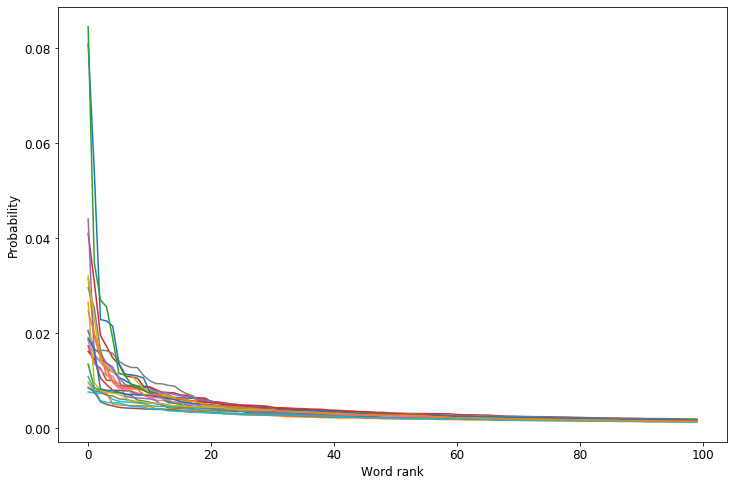

In [754]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 12, 8 
plt.rcParams['font.size'] = 12

# top 100 words by weight in each topic
top_n_words = 100
topics = model_list[22].show_topics(
    num_topics = 22, num_words = top_n_words, formatted = False)

for _, infos in topics:
    probs = [prob for _, prob in infos]
    plt.plot(range(top_n_words), probs)

plt.xlabel('Word rank')
plt.ylabel('Probability')
plt.show()

In [635]:
'''
In the above plot, each line corresponds to one of our ten topics. Notice how for each topic, the weights drop off sharply as we move down the ranked list of most important words. This shows that the top 10 to 20 words in each topic are assigned a much greater weight than the remaining words'''

'\nIn the above plot, each line corresponds to one of our ten topics. Notice how for each topic, the weights drop off sharply as we move down the ranked list of most important words. This shows that the top 10 to 20 words in each topic are assigned a much greater weight than the remaining words'

In [755]:
sent_topics_df = final[["combined"]]

In [757]:
b = [token[1] for token in final['top_topic']]
s = [token[0] for token in final['top_topic']]

In [758]:
final["topic"]= s

final["top_topic_Contribution"]= b

In [759]:
final["topic"]

0         11
1         11
2         11
3         14
4          9
          ..
245814     0
245815     0
245816     0
245817     9
245818     0
Name: topic, Length: 89372, dtype: int64

In [721]:
def kew(topic_num):
    wp = lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    return(topic_keywords)

In [645]:
final["topic_keywords"]= final["topic"].map(lambda token: kew(token))

In [646]:
final

,panelist_id,combined,top_topic,topic_distribution,dup_index,topic,top_topic_Contribution,topic_keywords
0,8a57a549864c2d18,Record-setting 17-foot long python found near ...,"(11, 0.4514289)","{0: 0, 1: 0, 2: 0, 3: 0, 4: 0.07778479, 5: 0, ...",0,11,0.451429,"study, human, plant, animal, climate_change, s..."
1,8a57a549864c2d18,Record-setting 17-foot long python found near ...,"(11, 0.4514289)","{0: 0, 1: 0, 2: 0, 3: 0, 4: 0.07778479, 5: 0, ...",0,11,0.451429,"study, human, plant, animal, climate_change, s..."
2,a24bd2910b9958bc,Record-setting 17-foot long python found near ...,"(11, 0.4514289)","{0: 0, 1: 0, 2: 0, 3: 0, 4: 0.07778479, 5: 0, ...",0,11,0.451429,"study, human, plant, animal, climate_change, s..."
3,3877b0a2652210fb,"Michael Cohen to CNN: FBI was 'professional, c...","(14, 0.329628)","{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.1624...",1,14,0.329628,"fbi, investigation, campaign, report, russian,..."
4,0359d4861f46ba23,"Grumpy Cat, the internet's most famous cat, de...","(9, 0.28125328)","{0: 0.22793244, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0.0...",2,9,0.281253,"child, family, life, mother, parent, woman, lo..."
...,...,...,...,...,...,...,...,...
245814,89ddf16139094817,Brie Larson's 'Avengers: Endgame' Premiere Loo...,"(0, 0.29491386)","{0: 0.29494599, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, ...",37887,0,0.294914,"star, love, film, work, play, hollywood, music..."
245815,89ddf16139094817,Brie Larson's 'Avengers: Endgame' Premiere Loo...,"(0, 0.29491386)","{0: 0.29494599, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, ...",37887,0,0.294914,"star, love, film, work, play, hollywood, music..."
245816,89ddf16139094817,Brie Larson's 'Avengers: Endgame' Premiere Loo...,"(0, 0.29491386)","{0: 0.29494599, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, ...",37887,0,0.294914,"star, love, film, work, play, hollywood, music..."
245817,3877b0a2652210fb,"In The Future, Will Your Kids Be Able To Sue Y...","(9, 0.48693994)","{0: 0.090653285, 1: 0, 2: 0, 3: 0, 4: 0.185424...",37888,9,0.486940,"child, family, life, mother, parent, woman, lo..."


In [647]:
def closest(topic_num, doc_num):
    v= final[final["topic"]==topic_num]
    v= v.nlargest(doc_num, 'top_topic_Contribution')
    return(v)

In [722]:
#sample article to get the proper label for each topic 
new_list=closest(22,200)
new_list

,panelist_id,combined,top_topic,topic_distribution,dup_index,topic,top_topic_Contribution
162313,b823867d34577003,Biden extends lead by 11 points in CNN poll wi...,"(22, 0.9877195)","{0: 15961, 1: 5820, 2: 7286, 3: 8772, 4: 12053...",27112,22,0.987719
147550,b823867d34577003,GOP voters more enthusiastic than Dems about p...,"(22, 0.97666013)","{0: 15961, 1: 5820, 2: 7286, 3: 8772, 4: 12053...",23537,22,0.976660
147551,b823867d34577003,GOP voters more enthusiastic than Dems about p...,"(22, 0.97666013)","{0: 15961, 1: 5820, 2: 7286, 3: 8772, 4: 12053...",23537,22,0.976660
147552,b823867d34577003,GOP voters more enthusiastic than Dems about p...,"(22, 0.97666013)","{0: 15961, 1: 5820, 2: 7286, 3: 8772, 4: 12053...",23537,22,0.976660
147553,b823867d34577003,GOP voters more enthusiastic than Dems about p...,"(22, 0.97666013)","{0: 15961, 1: 5820, 2: 7286, 3: 8772, 4: 12053...",23537,22,0.976660
...,...,...,...,...,...,...,...
227093,78004c406dd36a86,MSNBC’s Matthews Warns of 1972 Nixon-McGovern ...,"(22, 0.90458685)","{0: 15961, 1: 5820, 2: 7286, 3: 8772, 4: 12053...",34098,22,0.904587
75873,3958a8c8941d5160,Ocasio-Cortez Smarts Off To Democrat President...,"(22, 0.90263414)","{0: 15961, 1: 5820, 2: 7286, 3: 8772, 4: 12053...",14671,22,0.902634
56853,7cfdfcb57a5dfa00,Biden to criticize Trump's economic policy in ...,"(22, 0.90131587)","{0: 15961, 1: 5820, 2: 7286, 3: 8772, 4: 12053...",10845,22,0.901316
56854,7cfdfcb57a5dfa00,Biden to criticize Trump's economic policy in ...,"(22, 0.90131587)","{0: 15961, 1: 5820, 2: 7286, 3: 8772, 4: 12053...",10845,22,0.901316


In [649]:
print(''.join(map(str, data["text"][134789])))

Most economists still reject Professor Leontief’s analogy, but the conventional economic consensus is starting to fray. The productivity figures may not reflect it yet but new technology does seem more fundamentally disruptive than technologies of the past. Robots are learning on their own. Self-driving cars seem just a few regulations away from our city streets.As the idea sinks in that humans as workhorses might also be on the way out, what happens if the job market stops doing the job of providing a living wage for hundreds of millions of people? How will the economy spread money around, so people can afford to pay the rent?What if, say, the bottom quarter of the population in the United States and Europe simply couldn’t find a job at a wage that could cover the cost of basic staples? What if smart-learning machines took out lawyers and bankers? Or even, God forbid, journalists and economists?If you read my column last week you know the dim view I take of the Universal Basic Income 

In [760]:
topic_labels ={ 0: "Celebrity",
1: "Immigration",
2: "Political parties",
3: "International affairs",
4: "Social media ads",
5: "Disaster",
6: "Crime",
7: "Lifestyle", 
8: "Mueller investigation",
9: "Family stories",
10: "Restaurant reviews",
11: "Environmental issues",
12: "Weather Forecast",
13: "Racism",
14: "FBI cases",
 15: "Health",
 16: "Night stories",
 17: "Police",
 18: "Laws and bills",
 19: "Sports",
 20: "The education system",
 21: "Finance",
 22: "Presidential campaign"
}
empt=[]
for i in final['topic'].value_counts().index:
    empt.append(topic_labels[i])
final['topic'].value_counts()


17    9088
8     9043
22    6144
9     5219
0     5053
13    4527
3     4417
4     4380
12    3966
7     3808
21    3594
19    3593
18    3450
14    3405
6     3398
16    3239
11    2740
15    2512
1     2353
20    1624
2     1413
5     1258
10    1148
Name: topic, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text xticklabel objects>)

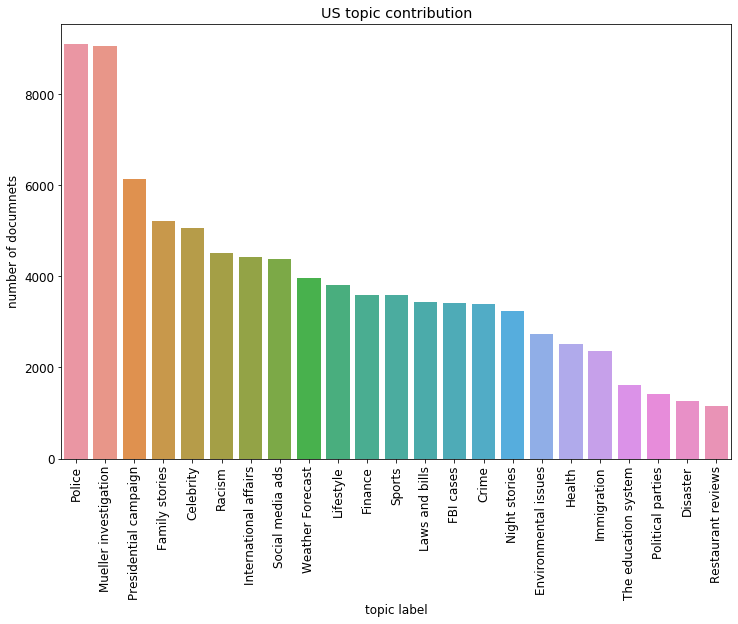

In [724]:
import seaborn 
ax=seaborn.barplot(x=empt, y=final['topic'].value_counts())
ax.set_title('US topic contribution')
ax.set_ylabel('number of documnets')
ax.set_xlabel('topic label')
plt.xticks(rotation=90)

# 4. User profile vectors

> In this part, we will be creating user profiles based on the "final" dataset.
 We will assign each "panelist_id" with normalized topic weights  

In [765]:
user_profile =final[["panelist_id","topic_distribution"]]
user_profile

,panelist_id,topic_distribution
0,8a57a549864c2d18,"{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ..."
1,8a57a549864c2d18,"{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ..."
2,a24bd2910b9958bc,"{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ..."
3,3877b0a2652210fb,"{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ..."
4,0359d4861f46ba23,"{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ..."
...,...,...
245814,89ddf16139094817,"{0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ..."
245815,89ddf16139094817,"{0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ..."
245816,89ddf16139094817,"{0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ..."
245817,3877b0a2652210fb,"{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ..."


In [770]:
user_profile =pd.concat([user_profile.drop(['topic_distribution'], axis=1), user_profile['topic_distribution'].apply(pd.Series)], axis=1)
user_profile

,panelist_id,0,1,2,3,4,5,6,7,8,...,13,14,15,16,17,18,19,20,21,22
0,8a57a549864c2d18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8a57a549864c2d18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,a24bd2910b9958bc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3877b0a2652210fb,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0359d4861f46ba23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245814,89ddf16139094817,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
245815,89ddf16139094817,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
245816,89ddf16139094817,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
245817,3877b0a2652210fb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [772]:
user_profile = user_profile.groupby(["panelist_id"]).sum()

In [773]:
user_profile['Max'] = user_profile[[x for x in range(23)]].idxmax(axis=1)
user_profile = user_profile.reset_index()

In [774]:
user_profile

,panelist_id,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,Max
0,006c503cad8cb405,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3
1,00c2347435c7d477,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,15
2,00c515cab74b184a,6,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,00d171d9c44c9268,1,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,6,0,21
4,00f7699b37f8077f,28,1,0,1,7,12,22,0,3,...,0,2,7,46,2,9,11,5,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,fdd5c2a67990d276,0,0,0,2,6,0,0,0,0,...,0,0,0,2,0,0,0,0,0,4
1057,ff6f20fbff8b2f3b,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,16
1058,ff9000000db10348,0,0,2,0,1,0,2,0,5,...,0,0,5,2,0,7,0,2,0,19
1059,ffaa2ba4414a716c,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,1,0,0,0,7


In [775]:
#number of panelists and the number of articles they read
panelist_occurence = pd.DataFrame(data.panelist_id.value_counts(),columns=['panelist_id'])

In [776]:
panelist_occurence.columns = ['occurence']
panelist_occurence["panelist_id"]=panelist_occurence.index
panelist_occurence

,occurence,panelist_id
f301c517cb335451,4932,f301c517cb335451
b823867d34577003,4771,b823867d34577003
201f1cb013f2c418,1949,201f1cb013f2c418
3274a30a658df34a,1798,3274a30a658df34a
cf79b97d26b1c10d,1633,cf79b97d26b1c10d
...,...,...
865b27546bd6278f,1,865b27546bd6278f
473d661921bf5042,1,473d661921bf5042
81c5965183ba6504,1,81c5965183ba6504
dd6068978aad7541,1,dd6068978aad7541


In [778]:
#combine the panelist_occurence list with 
user_profile = pd.concat([user_profile.set_index('panelist_id'),panelist_occurence.set_index('panelist_id')], axis=1, join='inner')

In [779]:
#Normalizing on the number of reads from each panelist
user_profile[lst]=user_profile[lst].div(user_profile.occurence, axis=0)

In [780]:
user_profile

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,Max,occurence
panelist_id,,,,,,,,,,,,,,,,,,,,,
006c503cad8cb405,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,3,2
00c2347435c7d477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15,1
00c515cab74b184a,0.461538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.307692,...,0.076923,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0,13
00d171d9c44c9268,0.066667,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.400000,0.000000,21,15
00f7699b37f8077f,0.107692,0.003846,0.000000,0.003846,0.026923,0.046154,0.084615,0.000000,0.011538,0.280769,...,0.007692,0.026923,0.176923,0.007692,0.034615,0.042308,0.019231,0.007692,9,260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fdd5c2a67990d276,0.000000,0.000000,0.000000,0.153846,0.461538,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,4,13
ff6f20fbff8b2f3b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16,1
ff9000000db10348,0.000000,0.000000,0.042553,0.000000,0.021277,0.000000,0.042553,0.000000,0.106383,0.063830,...,0.000000,0.106383,0.042553,0.000000,0.148936,0.000000,0.042553,0.000000,19,47


In [787]:
survey = pd.read_csv("/home/meftahzi/uk/survey/pypaneldata.csv", sep=';')
survey = survey[["issuesfirstW1",'panelist_id']]
survey

/home/meftahzi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,90,91,127,128,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,169,170,172,173,174,178,179,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,244,263,266,270,273,274,305,306,307,308,309,312,313,322,323,324,325,326,327,381,382,383,384,385,386,387,388,389,390,391,392,395,396,397,398,426,428,429,430,437,438,439,440,441,442,443,444,445,446,447,448,449,450,484,485,486,493,494,495,496,497,499,500,515,516,523,524,525,526,527,528,581,582,583,584,585,586,587,588,589,590,591,592,601,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,700,702,703,704,705,707,722,723,724,725,726,727,

,issuesfirstW1,panelist_id
0,Housing,9f9c5dbcffca934f
1,Terrorism,73d86cd8c95cc427
2,Pensions,b6d8a544bf3f964a
3,Housing,94b13804ff38645b
4,"The environment, climate and energy issues",ca3643404b4dc657
...,...,...
9620,Economic situation,2b2656054af3b0ad
9621,Immigration,da55959706cf69d4
9622,Crime,ac6468914d951125
9623,The education system,83a5674c712493a2


In [785]:
topic_labels

{0: 'Celebrity',
 1: 'Immigration',
 2: 'Political parties',
 3: 'International affairs',
 4: 'Social media ads',
 5: 'Disaster',
 6: 'Crime',
 7: 'Lifestyle',
 8: 'Mueller investigation',
 9: 'Family stories',
 10: 'Restaurant reviews',
 11: 'Environmental issues',
 12: 'Weather Forecast',
 13: 'Racism',
 14: 'FBI cases',
 15: 'Health',
 16: 'Night stories',
 17: 'Police',
 18: 'Laws and bills',
 19: 'Sports',
 20: 'The education system',
 21: 'Finance',
 22: 'Presidential campaign'}

In [784]:
user_profile = user_profile.rename(topic_labels)
user_profile

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,Max,occurence
panelist_id,,,,,,,,,,,,,,,,,,,,,
006c503cad8cb405,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,3,2
00c2347435c7d477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15,1
00c515cab74b184a,0.461538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.307692,...,0.076923,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0,13
00d171d9c44c9268,0.066667,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.400000,0.000000,21,15
00f7699b37f8077f,0.107692,0.003846,0.000000,0.003846,0.026923,0.046154,0.084615,0.000000,0.011538,0.280769,...,0.007692,0.026923,0.176923,0.007692,0.034615,0.042308,0.019231,0.007692,9,260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fdd5c2a67990d276,0.000000,0.000000,0.000000,0.153846,0.461538,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,4,13
ff6f20fbff8b2f3b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16,1
ff9000000db10348,0.000000,0.000000,0.042553,0.000000,0.021277,0.000000,0.042553,0.000000,0.106383,0.063830,...,0.000000,0.106383,0.042553,0.000000,0.148936,0.000000,0.042553,0.000000,19,47


In [789]:
fiw = user_profile.reset_index() 

fiw

,panelist_id,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,Max,occurence
0,006c503cad8cb405,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,3,2
1,00c2347435c7d477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15,1
2,00c515cab74b184a,0.461538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.076923,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0,13
3,00d171d9c44c9268,0.066667,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.400000,0.000000,21,15
4,00f7699b37f8077f,0.107692,0.003846,0.000000,0.003846,0.026923,0.046154,0.084615,0.000000,0.011538,...,0.007692,0.026923,0.176923,0.007692,0.034615,0.042308,0.019231,0.007692,9,260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,fdd5c2a67990d276,0.000000,0.000000,0.000000,0.153846,0.461538,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,4,13
1057,ff6f20fbff8b2f3b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16,1
1058,ff9000000db10348,0.000000,0.000000,0.042553,0.000000,0.021277,0.000000,0.042553,0.000000,0.106383,...,0.000000,0.106383,0.042553,0.000000,0.148936,0.000000,0.042553,0.000000,19,47
1059,ffaa2ba4414a716c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,7,6


In [792]:
fiw = pd.concat([fiw.set_index('panelist_id'),survey.set_index('panelist_id')], axis=1, join='inner')

In [793]:
fiw['Max']= fiw['Max'].apply(lambda x :  topic_labels[x])
fiw

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,Max,occurence,issuesfirstW1
panelist_id,,,,,,,,,,,,,,,,,,,,,
006c503cad8cb405,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,International affairs,2,Rising prices / inflation / cost of living
00c2347435c7d477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Health,1,Immigration
00c515cab74b184a,0.461538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.307692,...,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,Celebrity,13,Health and social security
00d171d9c44c9268,0.066667,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.066667,0.000000,0.000000,0.400000,0.000000,Finance,15,Health and social security
00f7699b37f8077f,0.107692,0.003846,0.000000,0.003846,0.026923,0.046154,0.084615,0.000000,0.011538,0.280769,...,0.026923,0.176923,0.007692,0.034615,0.042308,0.019231,0.007692,Family stories,260,Economic situation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fdd5c2a67990d276,0.000000,0.000000,0.000000,0.153846,0.461538,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,Social media ads,13,Immigration
ff6f20fbff8b2f3b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Night stories,1,Rising prices / inflation / cost of living
ff9000000db10348,0.000000,0.000000,0.042553,0.000000,0.021277,0.000000,0.042553,0.000000,0.106383,0.063830,...,0.106383,0.042553,0.000000,0.148936,0.000000,0.042553,0.000000,Sports,47,Other


### Topic/issue aggregation

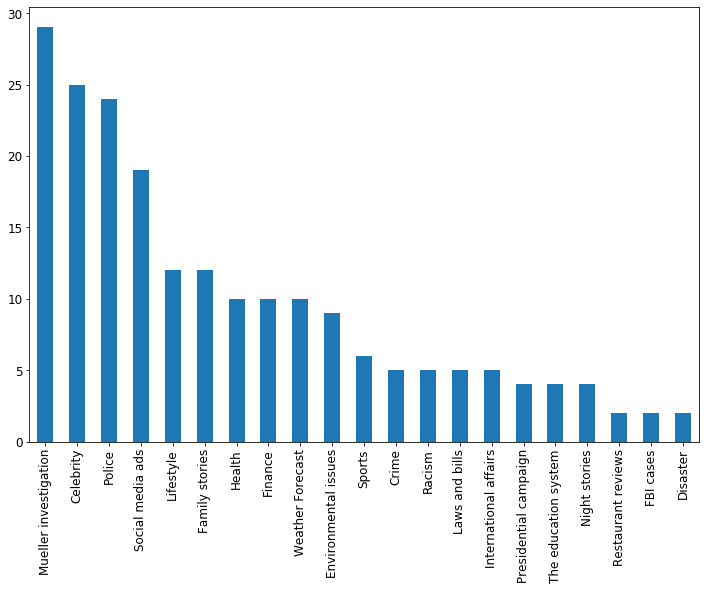

In [804]:
fiw[fiw["issuesfirstW1"]=="Health and social security"]['Max'].value_counts().plot(kind='bar')

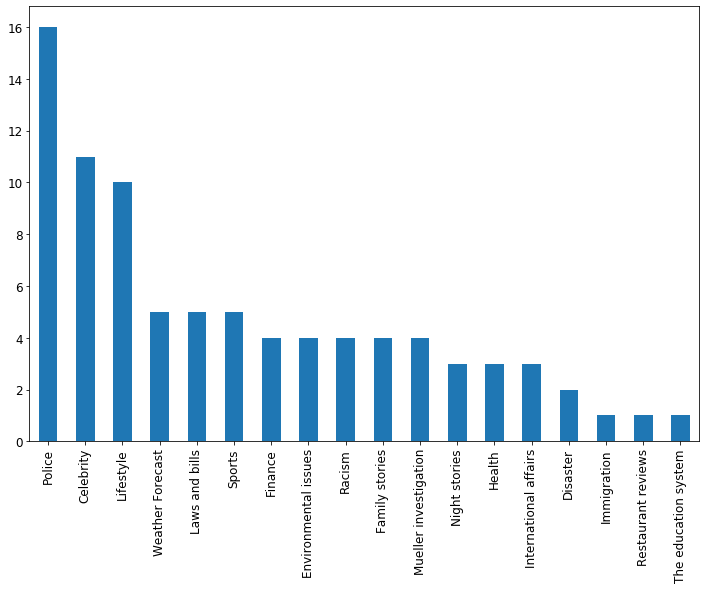

In [810]:
fiw[(fiw["issuesfirstW1"]=="Rising prices / inflation / cost of living")& (fiw['Max'] !="Social media ads")]['Max'].value_counts().plot(kind='bar')


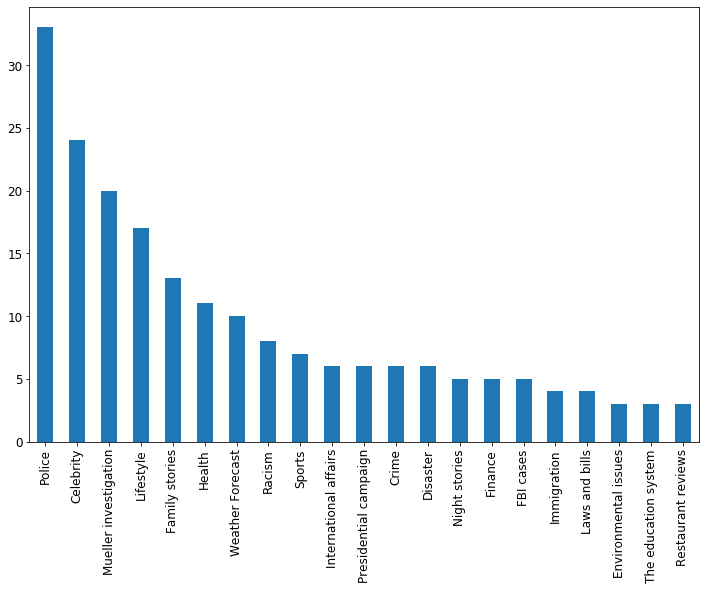

In [809]:
fiw[(fiw["issuesfirstW1"]=="Immigration")& (fiw['Max'] !="Social media ads")]['Max'].value_counts().plot(kind='bar')

Text(0, 0.5, 'number of panelists')

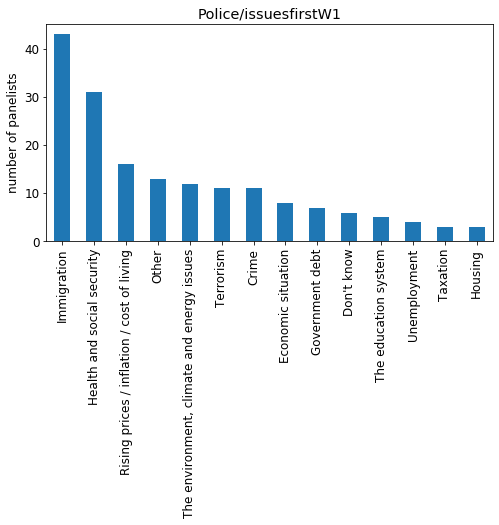

In [879]:
fiw[(fiw['Max'] =="Police") | (fiw['Max'] =="Crime") | (fiw['Max'] =="FBI cases")   ]["issuesfirstW1"].value_counts().plot(kind='bar',figsize=(8, 4))
plt.title("Police/issuesfirstW1")
plt.ylabel("number of panelists")

In [881]:
copyDF(pd.DataFrame(fiw['issuesfirstW1'].value_counts()))


<IPython.core.display.Javascript object>

Text(0, 0.5, 'number of panelists')

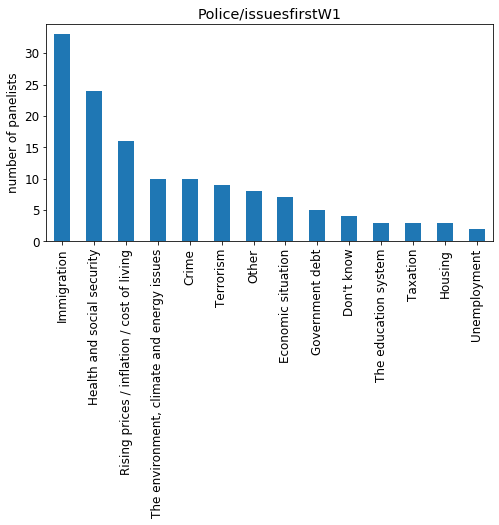

In [842]:
fiw[(fiw['Max'] =="Police")]["issuesfirstW1"].value_counts().plot(kind='bar',figsize=(8, 4))
plt.title("Police/issuesfirstW1")
plt.ylabel("number of panelists")

Text(0, 0.5, 'number of panelists')

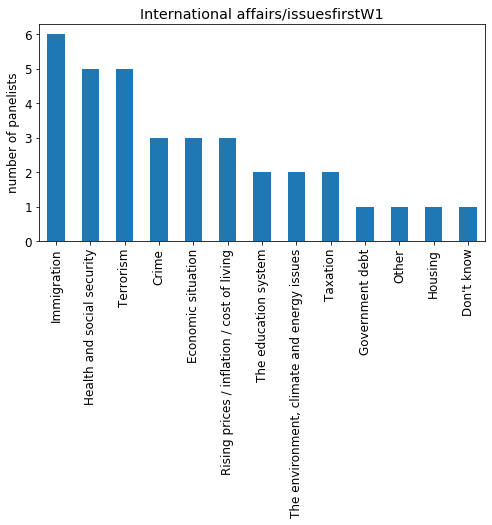

In [843]:
fiw[(fiw['Max'] =="International affairs")]["issuesfirstW1"].value_counts().plot(kind='bar',figsize=(8, 4))
plt.title("International affairs/issuesfirstW1")
plt.ylabel("number of panelists")

Text(0, 0.5, 'number of panelists')

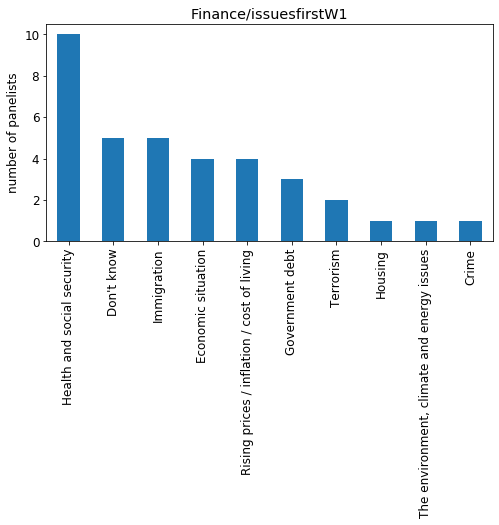

In [844]:
fiw[(fiw['Max'] =="Finance")]["issuesfirstW1"].value_counts().plot(kind='bar',figsize=(8, 4))
plt.title("Finance/issuesfirstW1")
plt.ylabel("number of panelists")

Text(0, 0.5, 'number of panelists')

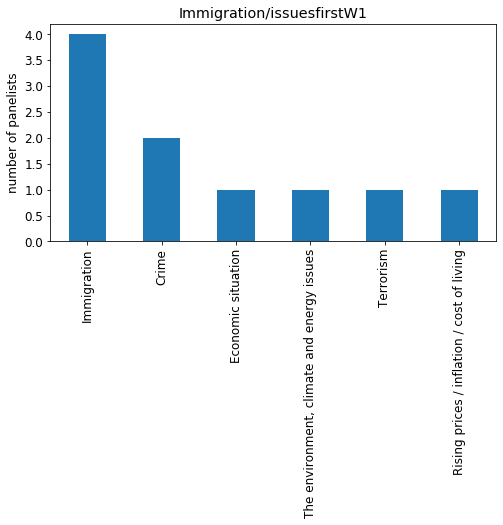

In [846]:
fiw[(fiw['Max'] =="Immigration")]["issuesfirstW1"].value_counts().plot(kind='bar',figsize=(8, 4))
plt.title("Immigration/issuesfirstW1")
plt.ylabel("number of panelists")

Text(0, 0.5, 'number of panelists')

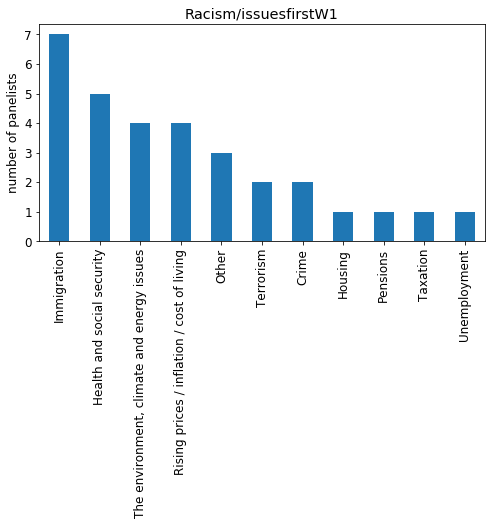

In [848]:
fiw[(fiw['Max'] =="Racism")]["issuesfirstW1"].value_counts().plot(kind='bar',figsize=(8, 4))
plt.title("Racism/issuesfirstW1")
plt.ylabel("number of panelists")

Text(0, 0.5, 'number of panelists')

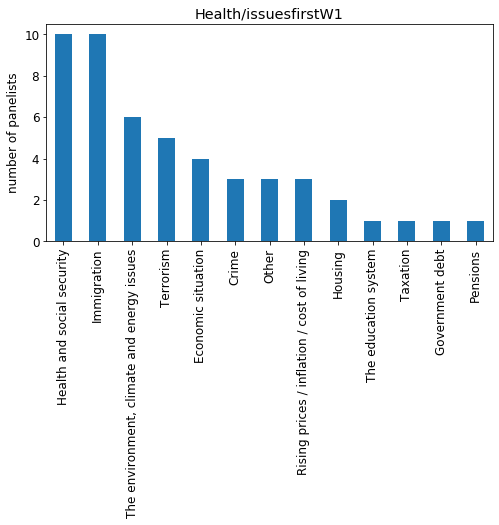

In [849]:
fiw[(fiw['Max'] =="Health")]["issuesfirstW1"].value_counts().plot(kind='bar',figsize=(8, 4))
plt.title("Health/issuesfirstW1")
plt.ylabel("number of panelists")

Text(0, 0.5, 'number of panelists')

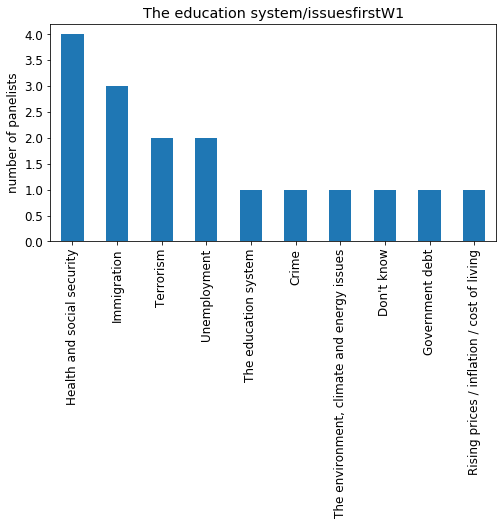

In [850]:

fiw[(fiw['Max'] =="The education system")]["issuesfirstW1"].value_counts().plot(kind='bar',figsize=(8, 4))
plt.title("The education system/issuesfirstW1")
plt.ylabel("number of panelists")

Text(0, 0.5, 'number of panelists')

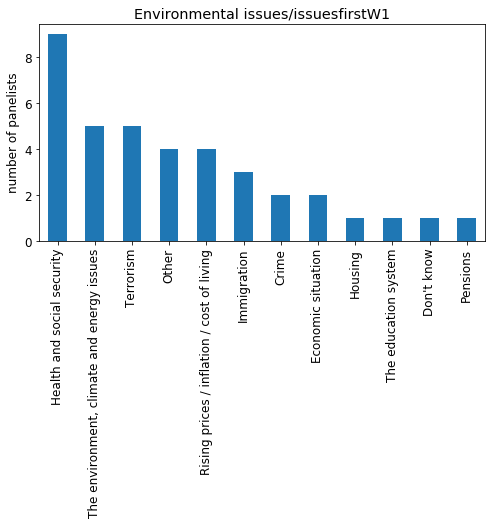

In [858]:
fiw[(fiw['Max'] =="Environmental issues")]["issuesfirstW1"].value_counts().plot(kind='bar',figsize=(8, 4))
plt.title("Environmental issues/issuesfirstW1")
plt.ylabel("number of panelists")

In [860]:
fiw["issuesfirstW1"].value_counts()

Health and social security                    204
Immigration                                   201
Rising prices / inflation / cost of living    104
Economic situation                             85
Terrorism                                      82
Other                                          78
The environment, climate and energy issues     70
Crime                                          62
Don't know                                     44
Government debt                                37
The education system                           29
Taxation                                       23
Unemployment                                   20
Housing                                        16
Pensions                                        6
Name: issuesfirstW1, dtype: int64

Text(0, 0.5, 'number of panelists')

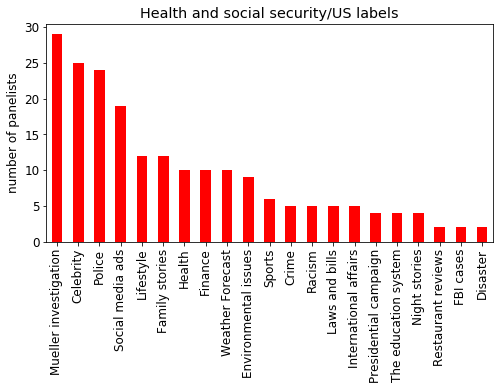

In [867]:
fiw[(fiw['issuesfirstW1'] =="Health and social security")]["Max"].value_counts().plot(kind='bar',figsize=(8, 4), color='r')
plt.title("Health and social security/US labels")
plt.ylabel("number of panelists")

Text(0, 0.5, 'number of panelists')

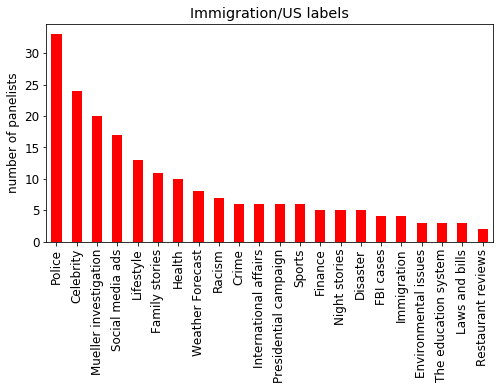

In [872]:
fiw[(fiw['issuesfirstW1'] =="Immigration")]["Max"].value_counts().plot(kind='bar',figsize=(8, 4), color='r')
plt.title("Immigration/US labels")
plt.ylabel("number of panelists")

Text(0, 0.5, 'number of panelists')

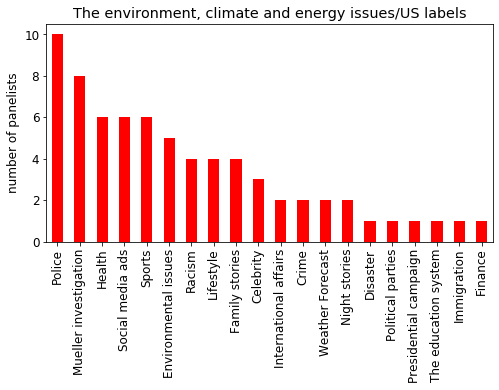

In [869]:
fiw[(fiw['issuesfirstW1'] =="The environment, climate and energy issues")]["Max"].value_counts().plot(kind='bar',figsize=(8, 4), color='r')
plt.title("The environment, climate and energy issues/US labels")
plt.ylabel("number of panelists")

Text(0, 0.5, 'number of panelists')

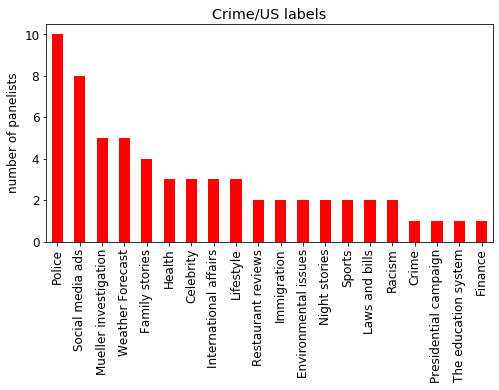

In [870]:
fiw[(fiw['issuesfirstW1'] =="Crime")]["Max"].value_counts().plot(kind='bar',figsize=(8, 4), color='r')
plt.title("Crime/US labels")
plt.ylabel("number of panelists")

Text(0, 0.5, 'number of panelists')

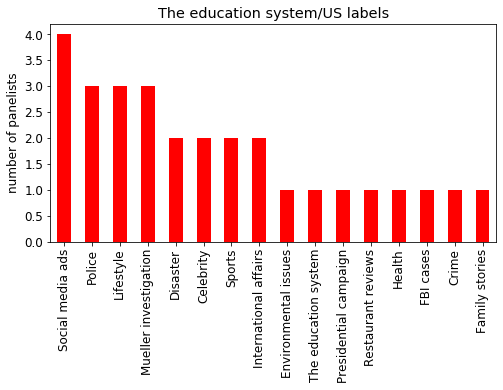

In [871]:
fiw[(fiw['issuesfirstW1'] =="The education system")]["Max"].value_counts().plot(kind='bar',figsize=(8, 4), color='r')
plt.title("The education system/US labels")
plt.ylabel("number of panelists")

In [852]:
fiw['issuesfirstW1'].value_counts()

Health and social security                    204
Immigration                                   201
Rising prices / inflation / cost of living    104
Economic situation                             85
Terrorism                                      82
Other                                          78
The environment, climate and energy issues     70
Crime                                          62
Don't know                                     44
Government debt                                37
The education system                           29
Taxation                                       23
Unemployment                                   20
Housing                                        16
Pensions                                        6
Name: issuesfirstW1, dtype: int64